In [1]:
# general utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils_CN
import os
import scipy.stats as ss
import scikit_posthocs as sp
import time
import joblib
import seaborn as sns
import math
from statsmodels.stats.proportion import proportion_confint
from utils_CN import calculate_trended_lr, remove_corr_features, cramers_v_association, remove_assoc_features, univariate_cat, univariate_num
from itertools import product
from sklearn.base import BaseEstimator, TransformerMixin

# modelling
import xgboost as xgb
import shap
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, auc, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, KFold, StratifiedGroupKFold, GroupKFold, cross_val_predict, cross_val_score
#from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# global plotting params
%matplotlib inline
plt.rcParams["figure.figsize"]=20,14
textsize = 25

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Loading dataset

In [2]:
base_data_path = "/SharedWithSome/smc-lawyers/LR_Hotspots/merged_datasets/"
merged_df = pd.read_csv(os.path.join(base_data_path, "sml_merged.csv"), parse_dates = ["effective_date"], low_memory=False)

# import dtypes pre-processing

## date dtype casting

In [3]:
potential_dates = [ele for ele in merged_df.columns if "date" in ele or "dt" in ele]
merged_df = utils_CN.localize_dates(merged_df, potential_dates)

# Target variable

## Building "ultimate (not developed)" target variable. Note that in this calculation, nulls in ultimate loss are replaced with zero before computation.

In [4]:
merged_df = utils_CN.calculate_trended_lr(merged_df)

Testing if rounding has a large effect:

Making target +ve to allow me to explore models like Tweedie:

In [5]:
lr_threshold = 0.57

merged_df["bad_lr"] = merged_df["ultimate_trended_onlevel_lr"].apply(lambda x: 1 if x > lr_threshold else 0)

## Elminating rows with no target variable (note that all loss information is already filled in the target calculation function)

In [6]:
present_target_df = merged_df[merged_df["ultimate_trended_onlevel_lr"].notnull()]

In [7]:
present_target_df.shape

(77232, 535)

## Restricting policies to those beyond 2010

In [8]:
present_target_trunc_df = present_target_df[(present_target_df["effective_date"].dt.year > 2010) & (present_target_df["effective_date"].dt.year < 2022)]

In [9]:
present_target_trunc_df.shape

(42844, 535)

In [10]:
present_target_trunc_df["bad_lr"].value_counts()

0    41619
1     1225
Name: bad_lr, dtype: int64

# Feature pruning/engineering

## Dropping low-hanging duplicate fruit

In [11]:
potential_duplicates = [ele for ele in present_target_trunc_df.columns if ele[-2:] == "_x" or ele[-2:] == "_y"]
print(potential_duplicates)

['tech_upd_ts_x', 'program_description_x', 'stamp_date_x', 'valuation_date_x', 'total_incurred_incl_rec_x', 'program_description_y', 'tech_upd_ts_y', 'stamp_date_y', 'valuation_date_y', 'total_incurred_incl_rec_y']


Eliminating columns previous investigated in deduplication as PI (tech_upd_ts, stamp_date, valuation_date, total_incurred_incl_rec). Keeping those in small_midsize_lawyers except in total_incurred_incl_rec case.

In [12]:
preprocess_df = present_target_trunc_df.drop(columns=['tech_upd_ts_y', 'stamp_date_y', 'valuation_date_y', 'program_description_y', 'total_incurred_incl_rec_y'])

In [13]:
preprocess_df = preprocess_df.rename(columns = {'tech_upd_ts_x': 'tech_upd_ts', 'program_description_x': 'program_description',
                               'stamp_date_x': 'stamp_date', 'valuation_date_x': 'valuation_date',
                               'total_incurred_incl_rec_x': 'total_incurred_incl_rec'})

In [14]:
preprocess_df["ultimate_trended_onlevel_lr"].describe()

count    42844.000000
mean         0.717851
std         12.580030
min          0.000000
25%          0.000000
50%          0.001538
75%          0.015272
max       1524.773986
Name: ultimate_trended_onlevel_lr, dtype: float64

In [15]:
preprocess_df["dominat_aop_group"].head()

5684     High
5685    Avobe
5686    Avobe
5687    Below
5688    Below
Name: dominat_aop_group, dtype: object

In [16]:
preprocess_df["aop_above_average_risk"].head()

5684    0.00
5685    1.00
5686    0.54
5687    0.00
5688    0.00
Name: aop_above_average_risk, dtype: float64

## AOP feature engineering

Updating AOP columns here (which the business may do themselves in Stargate):

In [17]:
aop_cols = ['entertainment_sports',
            'personal_injury_and_negligence_plaintiff',
            'financial_planning',
            'intellectual_property_copyright',
            'intellectual_property_patent_trademark',
            'mergers_acquisitions',
            'commercial_and_business_litigation_defense',
            'employment_law_defense',
            'personal_injury_and_negligence_defense',
            'workers_comp_defense',
            'civil_rights_and_discrimination',
            'collection_bankruptcy',
            'commercial_and_business_litigation_defense_plaintiff',
            'estate_probate_trust',
            'family_law',
            'administrative_law',
            'admiralty_law',
            'admiralty_law_general',
            'admiralty_law_plaintiff',
            'antitrust_trade',
            'commercial_real_estate_closings',
            'commercial_real_estate_foreclosure',
            'commercial_real_estate_other',
            'commercial_real_estate_title',
            'communications_fcc',
            'construction_law',
            'consumer_law',
            'corporate_and_business_organization',
            'criminal',
            'employment_law_plaintiff',
            'environmental_law',
            'financial_institution',
            'government_contracts_relations',
            'healthcare',
            'immigration_naturalization',
            'insurance_coverage',
            'insurance_opinions',
            'intellectual_property_c_p_t_including_litigation',
            'intellectual_property_c_p_t_not_including_litigation',
            'international_law',
            'juvenile_court_proceeding',
            'labor_labor_representation',
            'labor_management_representation',
            'lobbying',
            'mediation_arbitration',
            'natural_resources_other',
            'natural_resources_title',
            'natural_resources_general',
            'other',
            'pension_employee_benefits',
            'plaintiff_class_action',
            'plaintiff_mass_tort',
            'residential_real_estate_closings',
            'residential_real_estate_foreclosure',
            'residential_real_estate_other',
            'residential_real_estate_title',
            'real_estate_residential', 
            'real_estate_commercial',
            'securities_law_incl_bonds_private_placements_and_limited_partnerships',
            'social_security_veterans_administration',
            'tax_ad_valorum',
            'taxation_opinions',
            'taxation_other',
            'taxation_general',
            'workers_comp_plaintiff',
            'defense']

aops_independent_risk = ['insurance', 'personal_injury_and_negligence_defense']
aops_low_risk = ['administrative_law', 'commercial_and_business_litigation_defense', 'criminal', 'employment_law_defense', 
                 'lobbying', 'mediation_arbitration', 'workers_comp_defense']
aops_below_average_risk = ['consumer_law', 'government_contracts_relations', 'immigration_naturalization', 'labor_management_representation']
aops_average_risk = ['admiralty_law_general', 'civil_rights_and_discrimination', 'construction_law', 'corporate_and_business_organization',
                    'family_law', 'healthcare', 'international_law', 'other', 'taxation_other', 'workers_comp_plaintiff']
aops_above_average_risk = ['antitrust_trade', 'collection_bankruptcy', 'commercial_and_business_litigation_defense_plaintiff', 'employment_law_plaintiff',
                          'entertainment_sports', 'environmental_law', 'estate_probate_trust', 'financial_institution',
                          'financial_planning', 'intellectual_property_copyright', 'labor_labor_representation', 'mergers_acquisitions',
                          'natural_resources_general', 'pension_employee_benefits', 'real_estate_residential', 'real_estate_commercial', 
                          'taxation_opinions']
aops_high_risk = ['intellectual_property_patent_trademark', 'personal_injury_and_negligence_plaintiff', 'plaintiff_class_action', 'plaintiff_mass_tort',
                 'securities_law_incl_bonds_private_placements_and_limited_partnerships']

precursor_aops_high_risk = ['intellectual_property_c_p_t_including_litigation', 'intellectual_property_c_p_t_not_including_litigation']
aops_high_risk.extend(precursor_aops_high_risk)

def return_cols_in_df(col_list, df):
    return list(set(col_list).intersection(set(df.columns)))

# over-writing existing AOP risk categories with new information from the business
preprocess_df["aop_independent_risk"] = preprocess_df[return_cols_in_df(aops_independent_risk, preprocess_df)].fillna(0).sum(axis = 1)/100.0
preprocess_df["aop_low_risk"] = preprocess_df[return_cols_in_df(aops_low_risk, preprocess_df)].fillna(0).sum(axis = 1)/100.0
preprocess_df["aop_below_average_risk"] = preprocess_df[return_cols_in_df(aops_below_average_risk, preprocess_df)].fillna(0).sum(axis = 1)/100.0
preprocess_df["aop_average_risk"] = preprocess_df[return_cols_in_df(aops_average_risk, preprocess_df)].fillna(0).sum(axis = 1)/100.0
preprocess_df["aop_above_average_risk"] = preprocess_df[return_cols_in_df(aops_above_average_risk, preprocess_df)].fillna(0).sum(axis = 1)/100.0
preprocess_df["aop_high_risk"] = preprocess_df[return_cols_in_df(aops_high_risk, preprocess_df)].fillna(0).sum(axis = 1)/100.0

# update max aop pct and max detailed aop
preprocess_df['max_detailed_aop_pct'] = preprocess_df[aop_cols].max(axis=1)
preprocess_df['max_detailed_aop_name'] = preprocess_df[aop_cols].idxmax(axis=1)

# remove aop columns (as the engineered versions exist)
aop_in_df = [col for col in aop_cols if col in preprocess_df.columns]
preprocess_df = preprocess_df.drop(columns= aop_in_df)

## Dropping uninformative/completely null columns

In [18]:
%%capture
preprocess_df = utils_CN.drop_const_null(preprocess_df)

In [19]:
preprocess_df.shape

(42844, 430)

## Dropping unique columns, or 'key' columns (don't want unique mappings to LR):

Completely unique:

### Dropping completely unique columns:

In [20]:
uniqueness = preprocess_df.nunique()/preprocess_df.shape[0]
high_cardinality_columns = preprocess_df.loc[:, (uniqueness == 1)].columns.tolist()
preprocess_df = preprocess_df.drop(columns=high_cardinality_columns)

What about columns with nearly unique values excluding nulls?

In [21]:
non_null_uniqueness = preprocess_df.nunique()/preprocess_df.count()
print(preprocess_df.loc[:, (non_null_uniqueness > 0.9 )].head())
print(preprocess_df.loc[:, (non_null_uniqueness > 0.9 )].columns)

      system_assign_id renewed_policy_number    null  \
5684      4.733994e+13       FNA337000103114 -2500.0   
5685      2.052864e+13                   NaN     NaN   
5686      6.368840e+12       FNA337010795807     NaN   
5687      9.907314e+13       FNA337010802001     NaN   
5688      9.563824e+13       FNA337010802002     NaN   

      loss_aop_admiralty_law_general  loss_aop_antitrust_trade  \
5684                             NaN                       NaN   
5685                             NaN                       NaN   
5686                             NaN                       NaN   
5687                             NaN                       NaN   
5688                             NaN                       NaN   

      loss_aop_civil_rights_and_discrimination  \
5684                                       NaN   
5685                                       NaN   
5686                                       NaN   
5687                                       NaN   
5688            

### removing 'key' columns:

In [22]:
preprocess_df = preprocess_df.drop(columns=["system_assign_id", "renewed_policy_number", "an_policy_biz_key_to_join", "an_policy_key_to_link", 
                                            "lawyers_policy_key_aop", "previous_policy_number", "sl_systemassignid", "quote_number"])

What about columns with nearly unique values excluding nulls?

## Investigating columns with high null fractions (those that aren't uniform, but are close)

In [23]:
preprocess_df.loc[:, (preprocess_df.isnull().mean() > 0.90)]

,cancellation_date,cancellation_month,cancellation_year,extended_reporting_period,renewed_cancellation_date,null,loss_aop_administrative_law,loss_aop_admiralty_law_general,loss_aop_antitrust_trade,loss_aop_civil_rights_and_discrimination,...,cl_count_incurred,cl_count_incurred_xs_100k,cl_count_incurred_xs_250k,cl_count_incurred_xs_500k,cl_count_incurred_xs_1M,ultimate_loss_factor,rate_tier_code,cancel_reason_code,cancel_reason,lawyers_surcharge
5684,NaT,NaN,NaN,NaN,NaT,-2500.0,NaN,NaN,NaN,NaN,...,2.0,0.0,0.0,0.0,0.0,6.620103,NaN,NaN,NaN,NaN
5685,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5686,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5687,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5688,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234055,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234056,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234057,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234058,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
preprocess_df = preprocess_df.drop(columns = ["null"])

Majority are losses specific to aop, or spare columns where the sparsity makes sense (cancellation date doesn't have to be present, as it is unlikely policies are cancelled etc). Other columns are these aop columns ("commercial_real_estate_title"... etc) which are sparse because they contain the proportion of the aop per policy (they sum to 100.0 on average).

## Dropping features that compose the target variable, and those that are linearly related (any loss or premiums data).

In [25]:
target_components = ["total_paid", "total_reserve", "ultimate_loss", "onlevel_premium", "loss_trend_factor", "total_incurred_incl_rec"]
target_comp_to_remove = [col for col in target_components if col in preprocess_df.columns]
preprocess_df = preprocess_df.drop(columns = target_comp_to_remove)

In [26]:
related_loss_terms = ["loss", "incurred", "ulae", "alae", "ibnr", "ibner", "cl_count"]
related_premium_terms = ["premium"]

potential_loss_cols = [col for col in preprocess_df.columns if any([x in col for x in related_loss_terms])]
potential_premium_cols = [col for col in preprocess_df.columns if any([x in col for x in related_premium_terms])]

potential_loss_to_remove = [col for col in potential_loss_cols if col in preprocess_df.columns]
potential_premium_to_remove = [col for col in potential_premium_cols if col in preprocess_df.columns]

print(potential_loss_to_remove)
print(potential_premium_to_remove)

print(len(potential_loss_to_remove) + len(potential_premium_to_remove))

preprocess_df = preprocess_df.drop(columns = potential_loss_cols)
preprocess_df = preprocess_df.drop(columns = potential_premium_cols)

['loss_aop_administrative_law', 'loss_aop_admiralty_law_general', 'loss_aop_antitrust_trade', 'loss_aop_civil_rights_and_discrimination', 'loss_aop_collection_bankruptcy', 'loss_aop_commercial_and_business_litigation_defense', 'loss_aop_commercial_and_business_litigation_defense_plaintiff', 'loss_aop_commercial_real_estate_title', 'loss_aop_construction_law', 'loss_aop_consumer_law', 'loss_aop_corporate_and_business_organization', 'loss_aop_criminal', 'loss_aop_employment_law_defense', 'loss_aop_employment_law_plaintiff', 'loss_aop_environmental_law', 'loss_aop_estate_probate_trust', 'loss_aop_family_law', 'loss_aop_financial_institution', 'loss_aop_financial_planning', 'loss_aop_government_contracts_relations', 'loss_aop_healthcare', 'loss_aop_immigration_naturalization', 'loss_aop_insurance', 'loss_aop_intellectual_property_copyright', 'loss_aop_intellectual_property_patent_trademark', 'loss_aop_labor_labor_representation', 'loss_aop_mediation_arbitration', 'loss_aop_mergers_acquisit

## Dropping date columns (duplicated in numerical "year", "month" entries and hard to imagine date plays a role, unless long running policies are enriched because they have low LR for example)

In [27]:
date_cols = preprocess_df.loc[:, preprocess_df.dtypes == "datetime64[ns, UTC]"].columns.tolist()

related_date_terms = ["month", "year", "quarter"]
date_related_cols = [col for col in preprocess_df.columns if any([x in col for x in related_date_terms])]

#date_related_cols = [ele for ele in preprocess_df.columns if "month" in ele]
date_cols.extend(date_related_cols)

In [28]:
preprocess_df = preprocess_df.drop(columns = date_cols)

In [29]:
preprocess_df.shape

(42844, 244)

## Removing "no-use" columns

In [30]:
# from original list from business, removed 'max_detailed_aop_pct','max_detailed_aop', added cancel related columns ('cancel_reason', 'cancel_reason_code', 'cancelled_count', 'cancelled_exposure')
# from original list from business, removed 'max_detailed_aop_pct','max_detailed_aop', added cancel related columns ('cancel_reason', 'cancel_reason_code', 'cancelled_count', 'cancelled_exposure')
nouse_cols = ['LimitAmount','DedAmount','zip_code_implied','IID', 'Program','cl_count','target_frequency','target_severity','total_paid', 'total_reserve',
              'total_incurred','cl_count_incurred','earned_exposure',"Debits_Deflated_Premium","premium","base_input_premium","New_Premium",
              "Renewal_Premium","Renewed_Premium","Expired_Premium","Cancelled_Premium","Inforce_Premium","Future_Premium","60_PREM",
              "Renewed_Premium_NAASREN","Expired_Premium_NAASREN","REN_PREMIUM","RERATED_PREMIUM","earned_premium",'time_to_expiring','Wtd_Debit_Amount',
              'Days_Inforce','WP_AOP_GFC_N','WP_AOP_LOW_RISK','WP_AOP_BELOWAVG_RISK','WP_AOP_AVG_RISK','WP_AOP_ABOVEAVG_RISK',
              'WP_AOP_HIGH_RISK','WP_AOP_GFC_Y_EX_RE', 'WP_AOP_GFC_Y_RE','EXP_DEBIT_DEFLATED_PREM','ONLEVEL_DEBIT_DEFLATED_PREM','PLANNED_PREMIUM',
              'PROD_CD','producer_code','UndwrNm','PA_Territory','PROG_DESC','Program_Territory','REN_EXPOSURE', 'REN_SE_MOD', 'REN_S_MOD', 'REN_E_MOD', 
              'earned_factor', 'RISK_IMPACT_OVERALL','NOTAR_Count','AR',"policy_number_5","previous_policy_number_5","prev_pol_total_incurred_5",
              "prev_pol_earned_premium_5","cl_count_incurred_5","earned_exposure_5",'policy_type_2',
              'tech_src_sys', 'tech_gold_copy_src_sys', 'tech_upd_ts', 'tech_src_sys_upd_ts','insured_name', 'underwriter','limit_amount','deductible_amount',
              'program_territory','pennsylvania_territory','program_description','debits_deflated_premium','zip_code','auto_renewal','not_auto_renewal_count',
              'alae_paid', 'alae_reserve', 'total_incurred_excl_rec', 'ulae_reserve', 'ulae_paid', 'ulae_recovery', 'cl_count_incurred_xs_100k', 
              'cl_count_incurred_xs_250k', 'cl_count_incurred_xs_500k', 'cl_count_incurred_xs_1M','new_premium','renewal_premium', 'renewed_premium','cancelled_premium', 
              'inforce_premium', 'future_premium', 'sixty_premium', 'renewed_premium_na_as_renewed', 'expired_premium_na_as_renewed', 'aop_low_risk_premium',
              'aop_below_average_risk_premium', 'aop_average_risk_premium', 'aop_above_average_risk_premium', 'aop_high_risk_premium', 'aop_greater_financial_crisis_excluding_real_estate_premium',
              'aop_greater_financial_crisis_real_estate_premium', 'aop_not_greater_financial_crisis_premium', 'experience_and_schedule_modifier_premium', 'schedule_modifier_premium',
              'experience_modifier_premium', 'debit_deflated_premium', 'renewed_policy_premium', 'renewed_policy_experience_and_schedule_modifier_premium', 'renewed_policy_schedule_modifier_premium',
              'renewed_policy_experience_modifier_premium', 'rerated_premium', 'onlevel_debit_deflated_premium', 'planned_premium','premium_renewed_production','premium_renewed_retention','territory_code',
              'state_name','fips_code_string','us_states_mapbox','program','expired_premium','onlevel_aop_exposure','onlevel_aop','onlevel_aop_rate',
              'ins_tenure_by_pol_length','prev_pol_total_incurred_1','prev_pol_total_incurred_2','prev_pol_total_incurred_3','prev_pol_total_incurred_4','prev_pol_total_incurred_5',
              'cl_count_incurred_1','cl_count_incurred_2','cl_count_incurred_3','cl_count_incurred_4','cl_count_incurred_5',
              'state_code', 'county','weighted_debit_amount','auto_renewal_count',
              "price_impact_miscellaneous","price_impact_pro_rata","price_impact_endorsement","price_impact_higher_rate","price_impact_webinar","price_impact_aop_adjustment",
              "price_impact_schedule_modifier","price_impact_aop","price_impact_step","price_impact_experience_modifier","price_impact_tier","price_impact_non_discretionary_modifier",
              "price_impact_size_of_firm","price_impact_attorney_count","price_impact_algorithm","price_impact_limit_deductible","price_impact_base_rate","price_impact_overall",
              "risk_impact_tier","risk_impact_base_rate","risk_impact_limit_deductible","risk_impact_algorithm","risk_impact_size_of_firm","risk_impact_schedule_modifier",
              "risk_impact_non_discretionary_modifier","risk_impact_experience_modifier","risk_impact_step","risk_impact_higher_rate","risk_impact_pro_rata","risk_impact_webinar",
              "risk_impact_aop_adjustment","risk_impact_endorsement","risk_impact_attorney_count","risk_impact_aop","risk_impact_overall","risk_impact_miscellaneous",
              
              'aop_greater_financial_crisis_excluding_real_estate_premium','aop_greater_financial_crisis_real_estate_premium','aop_not_greater_financial_crisis_premium',
              'aop_greater_financial_crisis_excluding_real_estate_exposure','aop_greater_financial_crisis_real_estate_exposure','aop_not_greater_financial_crisis_exposure',
              'max_aop_band_exposure','max_aop_band',
              'greatest_aop_group',
              'database_name', 'status_retention','status_retention_na_as_new', 'status_retention_na_as_renewed',
              'cancellation_indicator', 'cancelled_within_a_month', 'renewed_cancellation_indicator', 'renewed_cancelled_within_a_month_indicator',
              'extended_reporting_period',
              'expired_exposure',
               'entertainment_sports',
                'personal_injury_and_negligence_plaintiff',
                'financial_planning',
                'intellectual_property_copyright',
                'intellectual_property_patent_trademark',
                'mergers_acquisitions',
                'commercial_and_business_litigation_defense',
                'employment_law_defense',
                'personal_injury_and_negligence_defense',
                'workers_comp_defense',
                'civil_rights_and_discrimination',
                'collection_bankruptcy',
                'commercial_and_business_litigation_defense_plaintiff',
                'estate_probate_trust',
                'family_law',
                'administrative_law',
                'admiralty_law',
                'admiralty_law_plaintiff',
                'antitrust_trade',
                'commercial_real_estate_closings',
                'commercial_real_estate_foreclosure',
                'commercial_real_estate_other',
                'commercial_real_estate_title',
                'communications_fcc',
                'construction_law',
                'consumer_law',
                'corporate_and_business_organization',
                'criminal',
                'employment_law_plaintiff',
                'environmental_law',
                'financial_institution',
                'government_contracts_relations',
                'healthcare',
                'immigration_naturalization',
                'insurance_coverage',
                'insurance_opinions',
                'intellectual_property_c_p_t_including_litigation',
                'intellectual_property_c_p_t_not_including_litigation',
                'international_law',
                'juvenile_court_proceeding',
                'labor_labor_representation',
                'labor_management_representation',
                'lobbying',
                'mediation_arbitration',
                'natural_resources_other',
                'natural_resources_title',
                'other',
                'pension_employee_benefits',
                'plaintiff_class_action',
                'plaintiff_mass_tort',
                'residential_real_estate_closings',
                'residential_real_estate_foreclosure',
                'residential_real_estate_other',
                'residential_real_estate_title',
                'securities_law_incl_bonds_private_placements_and_limited_partnerships',
                'social_security_veterans_administration',
                'tax_ad_valorum',
                'taxation_opinions',
                'taxation_other',
                'workers_comp_plaintiff',
                'defense',
                'aop_greater_financial_crisis_excluding_real_estate',
                'real_estate_residential',
                'labor_representation',
                'aop_greater_financial_crisis_real_estate', 
                'cancel_reason', 
                'cancel_reason_code', 
                'cancelled_count', 
                'cancelled_exposure',
                'aop_low_risk_exposure',
                'aop_below_average_risk_exposure',
                'aop_average_risk_exposure',
                'aop_above_average_risk_exposure',
                'aop_high_risk_exposure',
                'rate_change',
                'defense_outside']

# ^ added cancel_" and aop exposure categories
nouse_present = list(set(nouse_cols).intersection(set(preprocess_df.columns)))
preprocess_df = preprocess_df.drop(columns = nouse_present)

## Separating nominal/numerical features

In [31]:
nominal_dtypes = ["object", "category"]
nominal_to_remove = ["mapped_policy_id", "renewed_policy_id"] # policy_id will be removed later
nominal_features = list(set(preprocess_df.select_dtypes(include=nominal_dtypes).columns.tolist()) ^ set(nominal_to_remove))
nominal_features.remove("policy_id")

preprocess_df = preprocess_df.drop(columns = nominal_to_remove)

In [32]:
print(nominal_features)
print(len(nominal_features))

['price_report_indicator', 'excludePABAR_vs_notexcludePABAR', 'deductible_type', 'max_detailed_aop_name', 'program_code', 'rating_program', 'policy_prefix_code', 'producer_id', 'legal_entity', 'size_of_firm_bucket', 'producer_external', 'policy_type', 'core_exited', 'producer', 'status_production_na_as_new', 'valid_invalid', 'high_risk_indicator', 'market', 'dominat_aop_group', 'POLICY_TYPE', 'above_average_risk_indicator', 'product_modified', 'lob_code', 'extended_reporting_period_type', 'risk_category', 'max_detailed_aop', 'product', 'admitted_vs_notadmitted', 'extended_reporting_period_indicator', 'producer_name', 'status_production', 'status_production_na_as_renewed', 'low_focus_risk_indicator', 'new_vs_renew', 'pa_other_states', 'limit_type']
36


In [33]:
preprocess_df.dtypes.value_counts()

float64    101
object      37
int64       22
dtype: int64

### Identifying numerical columns

In [34]:
numerical_dtypes = ["int64", "float64"]

numerical_features = preprocess_df.select_dtypes(include=numerical_dtypes).columns.tolist()
numerical_features.remove("ultimate_trended_onlevel_lr")
numerical_features.remove("bad_lr")

In [35]:
print(numerical_features)
print(len(numerical_features))

['occurrence_limit', 'aggregate_limit', 'per_claim_deductible_amount', 'aggregate_deductible_amount', 'days_inforce', 'new_count', 'renewal_count', 'renewed_count', 'expired_count', 'exposure', 'new_exposure', 'renewal_exposure', 'renewed_exposure', 'insurance', 'rule_1_total', 'rule_1_non_dabbler', 'rule_1_single_dabbler', 'rule_1_multiple_dabbler', 'rule_2_total', 'rule_2_non_dabbler', 'rule_2_single_dabbler', 'rule_2_multiple_dabbler', 'rule_3_total', 'rule_3_non_dabbler', 'rule_3_single_dabbler', 'rule_3_multiple_dabbler', 'renewed_days_inforce', 'sixty_expired_count', 'sixty_renewed_count', 'renewed_count_na_as_renewed', 'expired_count_na_as_renewed', 'aop_low_risk', 'aop_below_average_risk', 'aop_average_risk', 'aop_above_average_risk', 'aop_high_risk', 'not_greater_financial_crisis', 'AOP_adjustment_ratio', 'renewed_policy_exposure', 'experience_modification_factor', 'non_discretionary_modification_factor', 'size_of_firm_factor', 'base_rate_factor', 'webinar_factor', 'higher_rat

## dropping correlated/associated features

### numerical

Starting with numerical features. How are their null fractions?

In [36]:
preprocess_df[numerical_features].isnull().mean().value_counts()

0.000000    49
0.013024    45
0.001937     7
0.512627     7
0.010410     4
0.000023     2
0.875408     1
0.208314     1
0.210158     1
0.000140     1
0.024694     1
0.987093     1
0.965059     1
dtype: int64

For the majority of numerical features, neglecting nulls is ok to do (as default in pearson.corr). Here I remove features with > 0.9 correlation, and choosing features to remove in order of their average correlation with all other features:

In [37]:
numerical_to_keep = remove_corr_features(preprocess_df[numerical_features], 
                                         var_thr=None, corr_thr=0.90).columns.tolist()

After removing correlated features: 121 -> 64


### nominal

#### Exploring categorical features association (Cramer's V):

<AxesSubplot:xlabel='2', ylabel='1'>

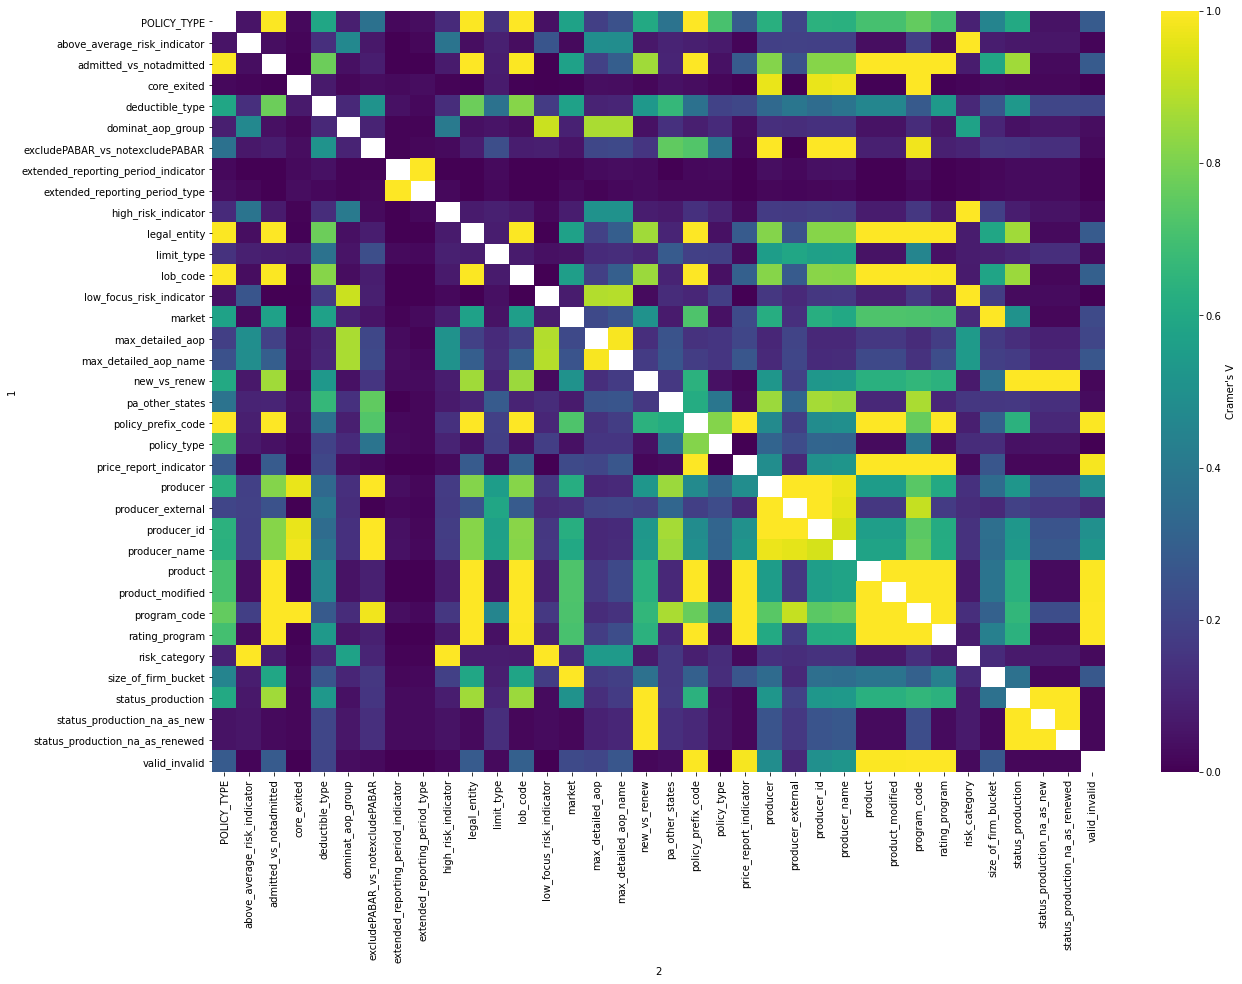

In [38]:
assoc_df = cramers_v_association(preprocess_df[nominal_features])
sns.heatmap(assoc_df, cbar_kws={"label": "Cramer's V"}, cmap="viridis")

In [39]:
nominal_to_keep = remove_assoc_features(preprocess_df[nominal_features], assoc_thr=1.0).columns.tolist()

After removing associated features: 36 -> 35


Showing an example of how useful this metric is to check for varying levels of association in categorical features:

In [40]:
preprocess_df[["product", "product_modified"]].value_counts()

product               product_modified
FLOW                  FLOW                41612
Non Admitted Lawyers  NONADMIT              904
LLF                   LLF                   235
Excess Lawyers        Excess Lawyers         82
Free Trade Zone       Free Trade Zone        11
dtype: int64

# Saving output for collaborative exploration:

In [41]:
keeping = numerical_to_keep.copy()
keeping.extend(nominal_to_keep)
keeping.append("bad_lr")
keeping.append("policy_id")
csv_save = preprocess_df[keeping]
csv_save.to_csv("classification_bad_lr_4_17_2023.csv")
print(len(keeping))

101


# test/train splitting

The important consideration here, as suggested by Ajay, is to ensure that there is no leakage by splitting based on policy_id. This handles cases where renewed policies have similar LR and features (which we don't want to breach the test/train divide).

In [42]:
gss = GroupShuffleSplit(test_size=.30, n_splits=2, random_state=42)
split = gss.split(preprocess_df, groups=preprocess_df['policy_id'])
train_idx, test_idx = next(split)

In [43]:
print(train_idx)

[    1     3     4 ... 42841 42842 42843]


verifying there are no shared policy_id between train and test:

In [44]:
unique_id_train = set(preprocess_df["policy_id"].iloc[train_idx].values.tolist())
unique_id_test = set(preprocess_df["policy_id"].iloc[test_idx].values.tolist())
print(unique_id_train.intersection(unique_id_test))

set()


In [45]:
train_df = preprocess_df.iloc[train_idx]
test_df = preprocess_df.iloc[test_idx]

print(train_df.shape)
print(test_df.shape)

(29991, 160)
(12853, 160)


In [46]:
X_train = train_df.drop(columns=["bad_lr", "ultimate_trended_onlevel_lr", "policy_id"])
X_test = test_df.drop(columns=["bad_lr", "ultimate_trended_onlevel_lr", "policy_id"])

y_train = train_df["bad_lr"]
y_test = test_df["bad_lr"]

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(29991, 157)
(12853, 157)
(29991,)
(12853,)


Ensuring a nice class distribution across train and test. Looks reasonable:

In [47]:
print(np.mean(y_train))
print(np.mean(y_test))

0.028241805875095862
0.029409476386835758


# Modelling

## logistic regression

In [48]:
# Custom Transformers (pipeline.fit calls fit then transform sequentially, predict just does transform (focus here))
class PandasCastTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, x, y = None):
        return self
    def transform(self, x):
        x = pd.DataFrame(x, columns = self.columns)
        return x

In [52]:
def LR_experiment(train_for_cv_df, X_train, y_train, feature_subset, n_iterations, name_for_model, name_for_results, description):
    
    gkf_cv = StratifiedGroupKFold(shuffle=True, random_state=42, n_splits=3)
    splitter_cv = gkf_cv.split(train_for_cv_df, y_train, groups=train_for_cv_df['policy_id'])
    
    lr_clf = LogisticRegression(random_state = 42, penalty = "l1", n_jobs = 1, solver='saga', max_iter=1000)

    start = time.time()
    
#     param_grid = {
#     'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'LR__penalty': ["elasticnet"],
#     'LR__l1_ratio': np.arange(0, 1.1, 0.1),
#     'oversample__sampling_strategy': np.arange(0.1, 0.5, 0.1),
#     'oversample__k_neighbors': [1, 2, 3, 4, 5],
#     'undersample__sampling_strategy': np.arange(0.3, 0.6, 0.1),
#     'fill_na__numerical__imputer__strategy': ["mean", "median"]    

#     }
    
    param_grid = {'undersample__sampling_strategy': [0.4], 
                  'oversample__sampling_strategy': [0.1], 
                  'oversample__k_neighbors': [1], 
                  'fill_na__numerical__imputer__strategy': ['median'], 
                  'LR__penalty': ['elasticnet'], 
                  'LR__l1_ratio': [0.8], 
                  'LR__C': [0.01]}
    
    # imputation/encoding of features
    ohe = OneHotEncoder(handle_unknown="ignore", max_categories=10)

    numerical_fill = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    categorical_fill = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value='nothing'))]
    )

    if len(feature_subset) > 0:
        numeric = list(set(numerical_to_keep).intersection(set(feature_subset)))
        nominal = list(set(nominal_to_keep).intersection(set(feature_subset)))
    else:
        numeric = numerical_to_keep
        nominal = nominal_to_keep
        
    fillna_transform = ColumnTransformer(
        transformers=[
            ("numerical", numerical_fill, numeric),
            ("nominal", categorical_fill, nominal)
        ])

    encode_transform = ColumnTransformer(
        transformers=[
            ("numerical", 'passthrough', numeric),
            ("nominal", ohe, nominal)
        ])
    
    columns_after_fill = numeric + nominal
    pipe = Pipeline(steps=[("fill_na", fillna_transform), ("topandas", PandasCastTransformer(columns = columns_after_fill)), 
                           ("oversample", SMOTENC(sampling_strategy=0.1, categorical_features = list(range(len(numeric), len(numeric) + len(nominal))))), 
                           ("undersample", RandomUnderSampler(sampling_strategy=0.4)), ("encode", encode_transform), ("LR", lr_clf)])

    lr_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring='roc_auc', 
                              cv=splitter_cv, n_jobs=16, return_train_score=True, n_iter=n_iterations, verbose=1)
    
    lr_search.fit(X_train, y_train)
    
    results = pd.DataFrame(lr_search.cv_results_).loc[:, "params":]
    results = pd.concat([pd.Series(description, index=results.index, name='description'), results], axis=1)
    
    if os.path.isfile(name_for_results):
        results[results["rank_test_score"] == 1].to_csv(name_for_results, mode='a', header=False)
    else:
         results[results["rank_test_score"] == 1].to_csv(name_for_results, mode='w', header=True)
    joblib.dump(lr_search.best_estimator_, name_for_model)
    end = time.time()
    
    print ("Time elapsed (in Sec):", end - start)
    return lr_search

def LR_experiment_weighting(train_for_cv_df, X_train, y_train, feature_subset, n_iterations, scoring, name_for_model, name_for_results, description):
    
    gkf_cv = StratifiedGroupKFold(shuffle=True, random_state=42, n_splits=3)
    splitter_cv = gkf_cv.split(train_for_cv_df, y_train, groups=train_for_cv_df['policy_id'])
    
    lr_clf = LogisticRegression(random_state = 42, penalty = "l1", n_jobs = 1, solver='saga', max_iter=1000)

    start = time.time()
    
    # for weighting
    frac_range = np.arange(0.30, 1.0, 0.05)
    
    param_grid = {
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'LR__penalty': ["elasticnet"],
    'LR__l1_ratio': np.arange(0, 1.1, 0.1),
    'fill_na__numerical__imputer__strategy': ["mean", "median"],
    'LR__class_weight': [{0: 1 - v, 1: v} for v in frac_range],
    }
    
#     param_grid = {'fill_na__numerical__imputer__strategy': ['mean'], 
#                   'LR__penalty': ['elasticnet'], 
#                   'LR__l1_ratio': [1.0], 
#                   'LR__class_weight': [{0: 0.050000000000000044, 1: 0.95}], 
#                   'LR__C': [0.1]}
    
    ohe = OneHotEncoder(handle_unknown="ignore", max_categories=10)

    numerical_fill = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    categorical_fill = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value='nothing'))]
    )

    if len(feature_subset) > 0:
        numeric = list(set(numerical_to_keep).intersection(set(feature_subset)))
        nominal = list(set(nominal_to_keep).intersection(set(feature_subset)))
    else:
        numeric = numerical_to_keep
        nominal = nominal_to_keep
        
    fillna_transform = ColumnTransformer(
        transformers=[
            ("numerical", numerical_fill, numeric),
            ("nominal", categorical_fill, nominal)
        ])

    encode_transform = ColumnTransformer(
        transformers=[
            ("numerical", 'passthrough', numeric),
            ("nominal", ohe, nominal)
        ])
    
    columns_after_fill = numeric + nominal
    
    pipe = Pipeline(steps=[("fill_na", fillna_transform), ("topandas", PandasCastTransformer(columns = columns_after_fill)),  
                       ("encode", encode_transform), ("LR", lr_clf)])

    lr_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring=scoring, 
                              cv=splitter_cv, n_jobs=10, return_train_score=True, n_iter=n_iterations, verbose=1)
    
    lr_search.fit(X_train, y_train)
    
    results = pd.DataFrame(lr_search.cv_results_).loc[:, "params":]
    results = pd.concat([pd.Series(description, index=results.index, name='description'), results], axis=1)
    
    if os.path.isfile(name_for_results):
        results[results["rank_test_score"] == 1].to_csv(name_for_results, mode='a', header=False)
    else:
         results[results["rank_test_score"] == 1].to_csv(name_for_results, mode='w', header=True)
    joblib.dump(lr_search.best_estimator_, name_for_model)
    end = time.time()
    
    print ("Time elapsed (in Sec):", end - start)
    return lr_search

In [50]:
def print_LR_metrics(search_object):
    print("Best parameters:", search_object.best_params_)
    print("Best Score (ROC_AUC): ", search_object.best_score_)
    print("ROC_AUC std: ", (search_object.cv_results_['std_test_score'][search_object.best_index_]))
    print("\n")

### Logistic regression baseline (all parameters)

In [ ]:
LR_search = LR_experiment(train_df, X_train, y_train, feature_subset = [], n_iterations=500, 
                          name_for_model="LRv1_best_estimator_ND.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [ ]:
%%capture cap
print("all features LR experiment\n")
print_LR_metrics(LR_search)

In [ ]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

In [98]:
# gkf_cv = GroupKFold()
# splitter_cv = gkf_cv.split(train_df, groups=train_df['policy_id'])

# fill_pipe = Pipeline(steps=[("fill_na", fillna_transform)])
# X_train_filled = pd.DataFrame(fill_pipe.fit_transform(X_train, y_train), columns = [ele.split('__')[1] for ele in fill_pipe.named_steps["fill_na"].get_feature_names_out()])
# for train, test in splitter_cv:
    
#     gt = y_train.values[test]
#     predicted = LR_search.predict(X_train_filled.loc[test, :])
    
#     #print(LR_search.predict(X_train_filled.loc[test, :]))
#     print(accuracy_score(gt, predicted), accuracy_score(gt, [0] * len(gt)))
#     #print(f1_score(gt, predicted), f1_score(gt, [1] * len(gt)))
#     #print(roc_auc_score(gt, predicted.sc), roc_auc_score(gt, [1] * len(gt)))

### Logistic (no-use removal: all parameters)

In [58]:
LR_search_useful = LR_experiment(train_df, X_train, y_train, feature_subset = useful_subset, n_iterations=500, 
                          name_for_model="LRv2_best_estimator_ND.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters (useful subset)")

NameError: name 'useful_subset' is not defined

In [ ]:
%%capture cap
print("all features LR experiment (useful subset) \n")
print_LR_metrics(LR_search_useful)

In [ ]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

In [ ]:
nominal_subset = set(nominal_to_keep) - set(nominal_to_keep).intersection(set(nouse_cols))
numerical_subset = set(numerical_to_keep) - set(numerical_to_keep).intersection(set(nouse_cols))
useful_subset = list(numerical_subset) + list(nominal_subset)

print(useful_subset)

### Logistic (weighting version)

In [ ]:
LR_search_weighting = LR_experiment_weighting(train_df, X_train, y_train, feature_subset = [], n_iterations=200, scoring='roc_auc',
                          name_for_model="LRv3_best_estimator_ND_weighted_removed2cols.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters 2 cols removed (weighted)")

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [ ]:
%%capture cap
print("all features LR experiment (weighted) \n")
print_LR_metrics(LR_search_weighting)

In [ ]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

### Logistic (weighting version, optimizing on f1 score)

In [89]:
LR_search_weighting = LR_experiment_weighting(train_df, X_train, y_train, feature_subset = [], n_iterations=100, scoring='f1',
                          name_for_model="LRv4_best_estimator_ND_weighted.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters (weighted, f1 score)")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Time elapsed (in Sec): 1581.1933410167694


The max_iter was reached which means the coef_ did not converge


In [90]:
%%capture cap
print("all features LR experiment (weighted) \n")
print_LR_metrics(LR_search_weighting)

In [91]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

all features LR experiment (weighted) 

Best parameters: {'fill_na__numerical__imputer__strategy': 'median', 'LR__penalty': 'elasticnet', 'LR__l1_ratio': 0.5, 'LR__class_weight': {0: 0.050000000000000044, 1: 0.95}, 'LR__C': 0.1}
Best Score (ROC_AUC):  0.1880938791257496
ROC_AUC std:  0.02826659904480438





### Logistic (weighting version, optimizing on recall)

In [93]:
LR_search_weighting = LR_experiment_weighting(train_df, X_train, y_train, feature_subset = [], n_iterations=100, scoring='recall',
                          name_for_model="LRv5_best_estimator_ND_weighted.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters (weighted, recall)")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Time elapsed (in Sec): 1742.5026931762695


The max_iter was reached which means the coef_ did not converge


In [94]:
%%capture cap
print("all features LR experiment (weighted, recall) \n")
print_LR_metrics(LR_search_weighting)

In [95]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

all features LR experiment (weighted, recall) 

Best parameters: {'fill_na__numerical__imputer__strategy': 'median', 'LR__penalty': 'elasticnet', 'LR__l1_ratio': 0.0, 'LR__class_weight': {0: 0.050000000000000044, 1: 0.95}, 'LR__C': 10}
Best Score (ROC_AUC):  0.42414021174404565
ROC_AUC std:  0.011644979841019445





### Logistic (no-use removal NEW standard)

In [67]:
LR_search_useful = LR_experiment(train_df, X_train, y_train, feature_subset = [], n_iterations=1, 
                          name_for_model="LRv6_best_estimator_ND.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters (new useful subset)")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Time elapsed (in Sec): 38.16347646713257


In [68]:
%%capture cap
print("all features LR experiment (useful subset) \n")
print_LR_metrics(LR_search_useful)

In [69]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

all features LR experiment (useful subset) 

Best parameters: {'undersample__sampling_strategy': 0.4, 'oversample__sampling_strategy': 0.1, 'oversample__k_neighbors': 1, 'fill_na__numerical__imputer__strategy': 'median', 'LR__penalty': 'elasticnet', 'LR__l1_ratio': 0.8, 'LR__C': 0.01}
Best Score (ROC_AUC):  0.762382522231038
ROC_AUC std:  0.021883877115897832





### Logistic (weighting version, optimizing on recall)

In [95]:
LR_search_weighting = LR_experiment_weighting(train_df, X_train, y_train, feature_subset = [], n_iterations=1, scoring='roc_auc',
                          name_for_model="LRv7_best_estimator_ND_weighted.pkl", name_for_results="LR_classification_ND.csv",
                          description = "LR all parameters (weighted, roc_auc)")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Time elapsed (in Sec): 205.33605456352234


The max_iter was reached which means the coef_ did not converge


In [96]:
%%capture cap
print("all features LR experiment (weighted, recall) \n")
print_LR_metrics(LR_search_weighting)

In [97]:
with open('LR_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

all features LR experiment (weighted, recall) 

Best parameters: {'fill_na__numerical__imputer__strategy': 'mean', 'LR__penalty': 'elasticnet', 'LR__l1_ratio': 1.0, 'LR__class_weight': {0: 0.050000000000000044, 1: 0.95}, 'LR__C': 0.1}
Best Score (ROC_AUC):  0.7599478691280669
ROC_AUC std:  0.02240346079123184





### evaluating model

#### ROC AUC for cross-fold validation

In [63]:
def roc_cv(train_for_cv_df, X, y, classifier, target, fontsize, filename):
    gkf_cv = StratifiedGroupKFold(shuffle=True, random_state=42, n_splits=3)
    splitter_cv = gkf_cv.split(train_for_cv_df, y_train, groups=train_for_cv_df['policy_id'])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(20, 14))
    for fold, (train, test) in enumerate(splitter_cv):

        classifier.fit(X_train.reset_index(drop=True).loc[train, :], y_train.iloc[train].values)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_train.reset_index().loc[test, :],
            y_train.iloc[test].values,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{target}')",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.title(f"Mean ROC curve with variability\n(Positive label '{target}')", fontsize = fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.yticks(size= fontsize)
    plt.xticks(size = fontsize)
    plt.legend(fontsize = fontsize)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


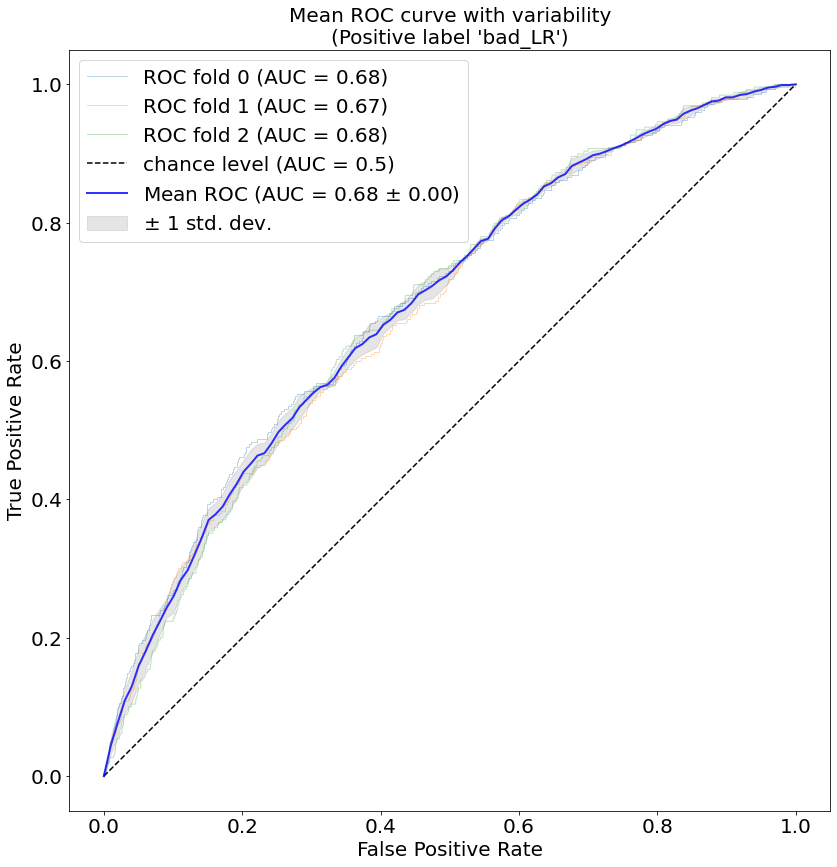

In [64]:
with open("LRv3_best_estimator_ND_weighted_removed2cols.pkl", 'rb') as file:
    log_reg = joblib.load(file)
    
roc_cv(train_df, X=X_train, y=y_train, classifier=log_reg, target='bad_LR', fontsize=20, filename="classificaion_roc_weighted_removed2cols.png")

#### confusion matricies

In [65]:
def confusion_cv(train_for_cv_df, X, y, classifier, fontsize, filename):
    gkf_cv = StratifiedGroupKFold(shuffle=True, random_state=42, n_splits=3)
    splitter_cv = gkf_cv.split(train_for_cv_df, y_train, groups=train_for_cv_df['policy_id'])
    
    y_pred = cross_val_predict(classifier, X, y, cv = splitter_cv)
    
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred, labels=classifier.classes_)
    
    sns.set(font_scale=1.5) # Adjust to fit
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g");
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
#     disp.plot(cmap=plt.cm.Blues)
    plt.yticks(size= fontsize)
    plt.xticks(size = fontsize)
    plt.ylabel("True label", size = fontsize)
    plt.xlabel("Predicted label", size = fontsize)
    #plt.rcParams.update({'font.size': 16})
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29144
           1       0.10      0.02      0.03       847

    accuracy                           0.97     29991
   macro avg       0.54      0.51      0.51     29991
weighted avg       0.95      0.97      0.96     29991



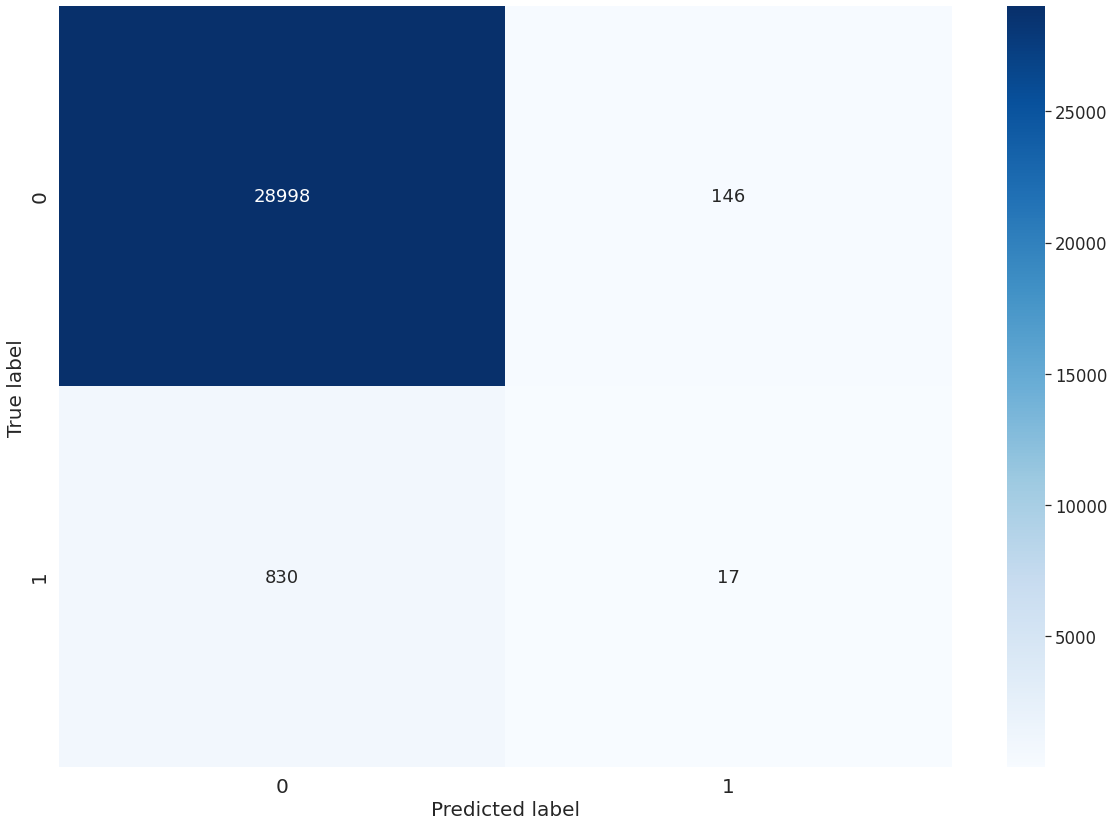

In [66]:
with open("LRv3_best_estimator_ND_weighted_removed2cols.pkl", 'rb') as file:
    log_reg = joblib.load(file)
    
confusion_cv(train_df, X_train, y_train, classifier=log_reg, fontsize=20, filename="confusion_cv_removed2cols.png")

### Intrinsic importance

In [161]:
top_x = 15
feature_names = numerical_to_keep + nominal_to_keep

First I will just look at nonzero coefficients (should be compared separately for categorical and numerical, strictly speaking):

['numerical__factor_aop_admiralty_law_general', 'numerical__quater', 'numerical__aop_average_risk', 'numerical__average_step_factor', 'numerical__insurance', 'numerical__factor_aop_financial_planning', 'nominal__above_average_risk_indicator_Y', 'numerical__factor_aop_taxation_other', 'numerical__insurance_company_id', 'numerical__pro_rata_factor', 'numerical__rule_1_non_dabbler', 'numerical__renewed_days_inforce', 'numerical__rule_3_total', 'numerical__factor_aop_pension_employee_benefits', 'numerical__renewed_exposure', 'numerical__rule_3_multiple_dabbler', 'numerical__edition', 'nominal__producer_PEARL INSURANCE GROUP LLC     ', 'nominal__producer_id_166691', 'numerical__rule_1_single_dabbler', 'numerical__non_discretionary_modification_factor', 'nominal__producer_name_PEARL INSURANCE GROUP LLC', 'numerical__days_inforce', 'nominal__max_detailed_aop_infrequent_sklearn', 'numerical__aop_below_average_risk', 'numerical__aop_above_average_risk', 'numerical__deductible_factor', 'nominal_

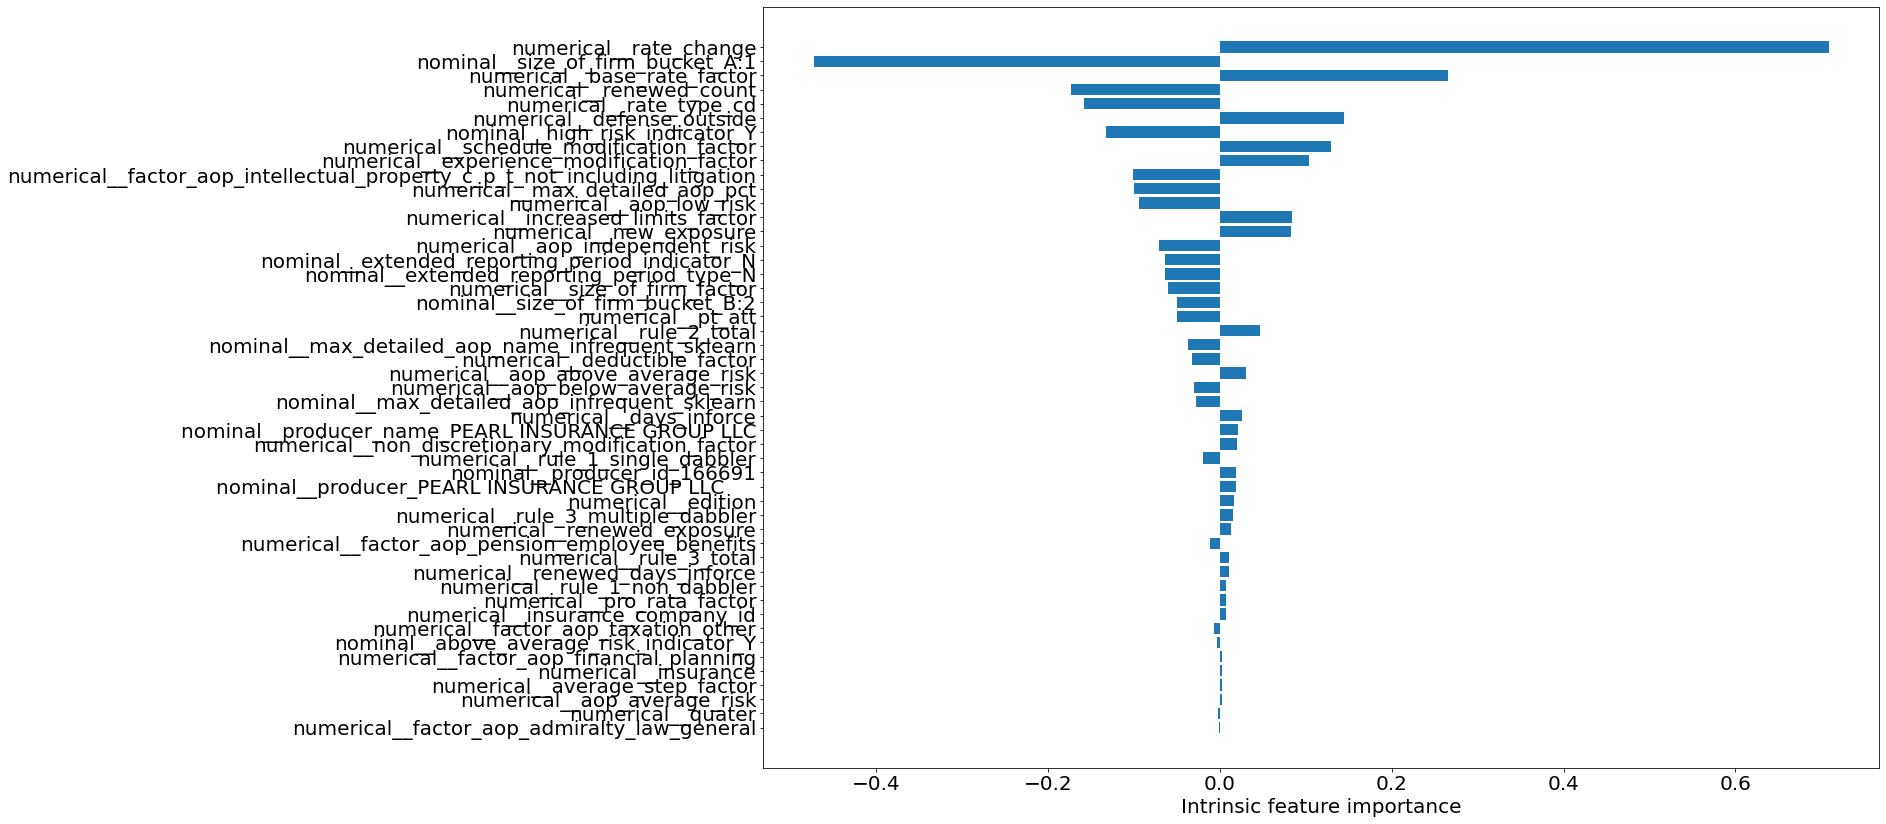

In [130]:
# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
with open("LRv7_best_estimator_ND_weighted.pkl", 'rb') as file:
    log_reg_usefulparam = joblib.load(file)

coefficients = log_reg_usefulparam.named_steps["LR"].coef_[0]
coef_columns = log_reg_usefulparam.named_steps["encode"].get_feature_names_out()

coef_col = zip(coefficients, coef_columns)
nonzero_coef = sorted([ele for ele in coef_col if ele[0] != 0], key= lambda x: abs(x[0]))
intrinsic_importance_top = [x[1] for x in nonzero_coef]

print(intrinsic_importance_top)
plt.barh([x[1] for x in nonzero_coef], [x[0] for x in nonzero_coef])
size=20
plt.xlabel("Intrinsic feature importance", fontsize=size)
plt.xticks(size=size)
plt.yticks(size=size)
#plt.xscale('log')
plt.show()

### Permutation importance

In [67]:
with open("LRv3_best_estimator_ND_weighted_removed2cols.pkl", 'rb') as file:
    log_reg_usefulparam = joblib.load(file)

feature_names = log_reg_usefulparam.named_steps["encode"].transformers_[0][2]  + log_reg_usefulparam.named_steps["encode"].transformers_[1][2]
perm = permutation_importance(log_reg_usefulparam, X_test.loc[:, feature_names], y_test, n_repeats = 50, scoring="roc_auc")

In [68]:
# only consider importances for included features
top_x = 15

perm_idx_sorted = perm.importances_mean.argsort()[::-1]
perm_importance_top = [ele[1] for ele in zip(np.array(perm.importances_mean)[perm_idx_sorted], np.array(feature_names)[perm_idx_sorted]) if ele[0] > 0]

perm_top_x = [str(ele) for ele in list(np.array(feature_names)[perm_idx_sorted][0:top_x])]
print(perm_importance_top)
print(len(perm_importance_top))
print(perm_top_x)
print(len(perm_top_x))
print([type(ele) for ele in perm_top_x])
print(np.array(perm.importances_mean)[perm_idx_sorted])
print([ele[0] for ele in zip(np.array(perm.importances_mean)[perm_idx_sorted], np.array(feature_names)[perm_idx_sorted]) if ele[0] > 0])

['size_of_firm_bucket', 'increased_limits_factor', 'renewed_exposure', 'max_detailed_aop_pct', 'rate_type_cd', 'aop_above_average_risk', 'schedule_modification_factor', 'base_rate_factor', 'experience_modification_factor', 'deductible_factor', 'pa_other_states', 'dominat_aop_group', 'average_step_factor', 'aop_low_risk', 'factor_aop_residential_real_estate_title', 'pt_att', 'aop_independent_risk', 'policy_prefix_code', 'renewed_count', 'size_of_firm_factor', 'insurance', 'factor_aop_intellectual_property_c_p_t_not_including_litigation', 'max_detailed_aop_name', 'high_risk_indicator', 'max_detailed_aop', 'new_count', 'tier_rate', 'new_exposure', 'above_average_risk_indicator', 'deductible_type', 'non_discretionary_modification_factor', 'days_inforce', 'factor_aop_financial_planning', 'occurrence_limit', 'renewed_days_inforce', 'limit_type', 'risk_category', 'program_code', 'extended_reporting_period_indicator', 'factor_aop_family_law', 'pro_rata_factor', 'rule_3_total', 'producer', 'pro

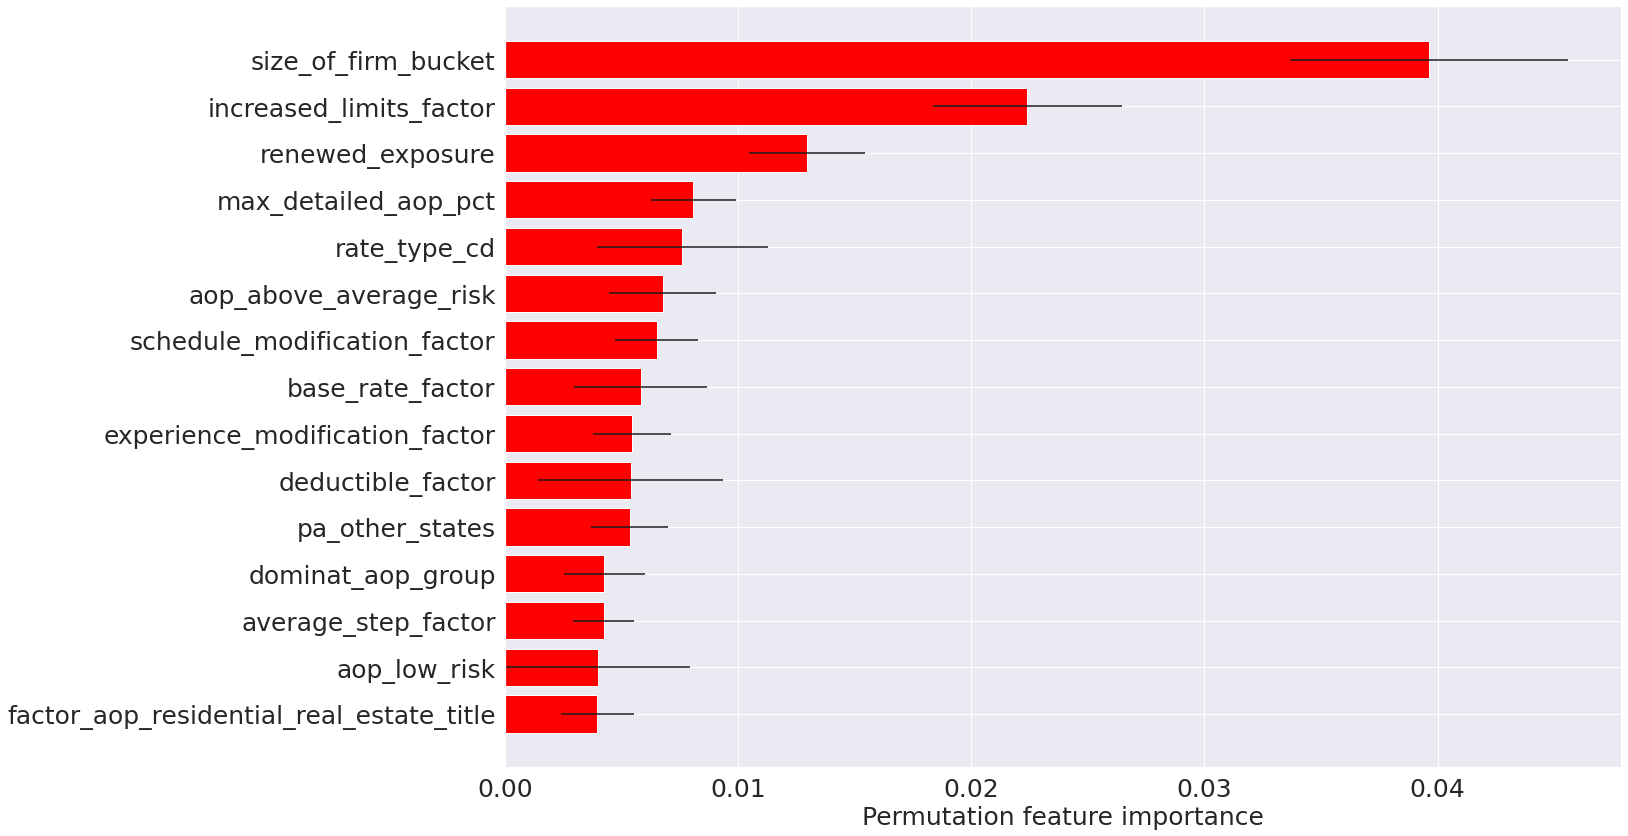

In [69]:
size=25
plt.barh(np.asarray(feature_names)[perm_idx_sorted][0:top_x][::-1], np.asarray(perm.importances_mean)[perm_idx_sorted][0:top_x][::-1], xerr= perm.importances_std[perm_idx_sorted][0:top_x][::-1], color='red')
plt.xlabel("Permutation feature importance", fontsize=size)
plt.xticks(size=size)
plt.yticks(size=size)
#plt.xscale('log')
plt.savefig("permutation_importance_classification_newpreprocessing_removed2cols.png", dpi=300, bbox_inches="tight")
plt.show()

### SHAP importance

In [168]:
pred = log_reg_usefulparam.predict(X_train)
X_shap = Pipeline(log_reg_usefulparam.steps[:-1]).transform(X_train)
explainer = shap.LinearExplainer(log_reg_usefulparam.named_steps["LR"], X_shap)
shap_values = explainer.shap_values(X_shap)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

48.06074480655252

(29991, 240)
(29991, 240)


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

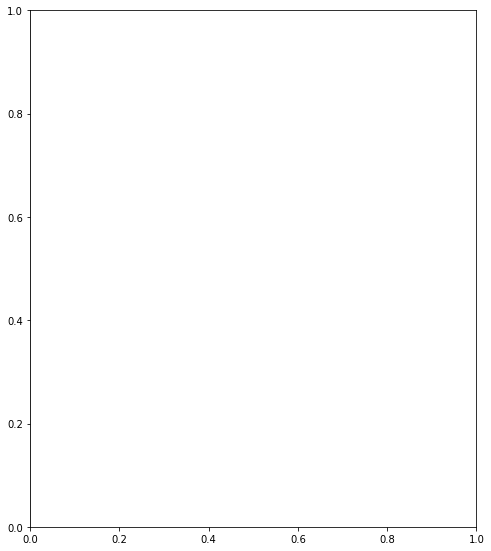

In [170]:
print(shap_values.shape)
print(X_shap.shape)
shap.summary_plot(shap_values)

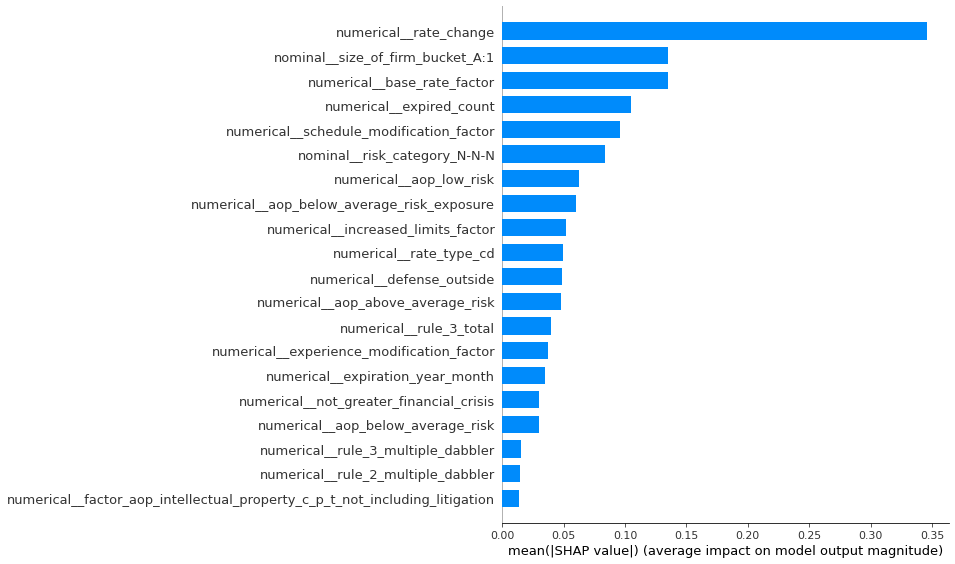

In [175]:
shap.summary_plot(shap_values, max_display=20, plot_type='bar', feature_names = log_reg_usefulparam.named_steps["encode"].get_feature_names_out(), show=False)
plt.savefig("classification_SHAP_importance.png", dpi=300, bbox_inches='tight')

In [111]:
shap_val_df = pd.DataFrame(shap_values, columns = LR_search.best_estimator_.named_steps["encode"].get_feature_names_out())
shap_top_x = list(shap_val_df.abs().mean(axis=0).sort_values(ascending=False).index[:top_x])
print(shap_top_x)

['numerical__auto_renewal_count', 'numerical__rate_change', 'numerical__max_detailed_aop_pct', 'numerical__pt_att', 'numerical__increased_limits_factor', 'numerical__rule_2_total', 'nominal__insured_name_infrequent_sklearn', 'numerical__rule_2_non_dabbler', 'nominal__program_code_304001', 'numerical__tenure', 'nominal__deductible_amount_5000|', 'nominal__deductible_type_Loss & Expense', 'nominal__risk_category_N-N-N', 'numerical__rule_3_total', 'nominal__max_detailed_aop_infrequent_sklearn']


In [186]:
preprocess_df[["aop_above_average_risk", "aop_above_average_risk_exposure"]].value_counts()

aop_above_average_risk  aop_above_average_risk_exposure
0.00000                 0.0000                             11348
1.00000                 1.0000                              1619
0.05000                 0.0500                               799
0.10000                 0.1000                               777
0.20000                 0.2000                               700
                                                           ...  
0.43990                 15.0117                                1
0.15000                 3.4500                                 1
                        4.6500                                 1
0.43898                 18.8770                                1
1.68655                 115.7821                               1
Length: 4102, dtype: int64

### LR v2 (truncating features)

### intrinsic feature importance results

In [632]:
print(intrinsic_importance_top)

['numerical__risk_impact_pro_rata', 'numerical__average_step_factor', 'numerical__non_discretionary_modification_factor', 'numerical__tenure', 'numerical__factor_aop_intellectual_property_c_p_t_not_including_litigation', 'numerical__increased_limits_factor', 'numerical__rule_2_total', 'numerical__rule_2_non_dabbler', 'numerical__max_detailed_aop_pct', 'numerical__pt_att', 'nominal__insured_name_infrequent_sklearn', 'numerical__rate_change', 'numerical__not_auto_renewal_count']


In [154]:
cols_prefix_removed = ["".join(ele.split('__')[1:]) if 'numerical' in ele else "_".join("".join(ele.split('__')[1:]).split('_')[:-2]) for ele in intrinsic_importance_top]
print(cols_prefix_removed)
LR_intrinsic_search = LR_experiment(train_df, X_train, y_train, feature_subset = cols_prefix_removed, n_iterations=500, 
                          name_for_model="LRv2_intrinsic_best_estimator.pkl", name_for_results="LR_classification.csv",
                          description = "LR intrinsic importance parameters")

['aop_above_average_risk_exposure', 'rule_2_multiple_dabbler', 'POLICY', 'max_aop_band_aop_above_average', 'status_retention_na_as', 'max_detailed_aop_estate', 'aop_high_risk_exposure', 'program_territory', '', 'aop_greater_financial_crisis_excluding_real_estate', 'deductible', 'price_impact_experience_modifier', 'rule_3_multiple_dabbler', 'program', 'rule_3_non_dabbler', 'aop_greater_financial_crisis_real_estate', 'aop_greater_financial_crisis_excluding_real_estate_exposure', 'limit', 'high_risk', 'deductible_amount', 'deductible', 'high_risk', 'real_estate_commercial', 'average_step_factor', 'non_discretionary_modification_factor', 'zip_code', 'rule_3_total', 'limit', 'risk_impact_attorney_count', 'aop_average_risk_exposure', 'program', 'policy_prefix', 'tenure', 'rule_2_non_dabbler', 'risk', 'aop_below_average_risk_exposure', 'factor_aop_intellectual_property_c_p_t_not_including_litigation', 'rule_2_total', 'max_detailed_aop', 'deductible', 'deductible', 'program', 'increased_limits


129 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
129 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/usr/local/lib/python3.8/dist-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/

Time elapsed (in Sec): 342.60447907447815


In [155]:
%%capture cap
print("intrinsic importance features LR experiment\n")
print_LR_metrics(LR_intrinsic_search)

In [156]:
with open('classification_stratified.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

intrinsic importance features LR experiment

Best parameters: {'undersample__sampling_strategy': 0.3, 'oversample__sampling_strategy': 0.30000000000000004, 'oversample__k_neighbors': 1, 'fill_na__numerical__imputer__strategy': 'mean', 'LR__penalty': 'elasticnet', 'LR__l1_ratio': 0.0, 'LR__C': 0.001}
Best Score (ROC_AUC):  0.7871509757284697
ROC_AUC std:  0.008074602010527059





### permutation truncation importance results

In [164]:
LR_perm_search = LR_experiment(train_df, X_train, y_train, feature_subset = perm_top_x, n_iterations=500, 
                          name_for_model="LRv2_perm_best_estimator_15.pkl", name_for_results="LR_classification.csv",
                          description = "LR permutation importance parameters (top 15)")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits



168 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
168 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/usr/local/lib/python3.8/dist-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/

Time elapsed (in Sec): 128.1446123123169


The max_iter was reached which means the coef_ did not converge


In [165]:
%%capture cap
print("perm importance features LR experiment (top 15)\n")
print_LR_metrics(LR_perm_search)

In [166]:
with open('LR_classification.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

perm importance features LR experiment (top 15)

Best parameters: {'undersample__sampling_strategy': 0.3, 'oversample__sampling_strategy': 0.1, 'oversample__k_neighbors': 3, 'fill_na__numerical__imputer__strategy': 'mean', 'LR__penalty': 'elasticnet', 'LR__l1_ratio': 0.1, 'LR__C': 0.01}
Best Score (ROC_AUC):  0.7932518529042044
ROC_AUC std:  0.009031295226005116





### SHAP importance results

In [ ]:
# # X_2_train = xgb_search.best_estimator_.named_steps["encoding"].get_feature_names_out()
# X_shap_train = pd.DataFrame(xgb_search.best_estimator_.named_steps["encoding"].transform(X_train), 
#              columns = xgb_search.best_estimator_.named_steps["encoding"].get_feature_names_out(), 
#              index = X_train.index)[list(shap_top_x)]

# X_shap_train.head()

In [ ]:
# xgb_shap_search = XGB_experiment(train_df, X_shap_train, y_train, encode=False, n_iterations=30, name_for_save="XGBv2_shap_best_estimator.pkl")

In [ ]:
# %%capture cap
# print("shap importance features (30) XGB regression experiment\n")
# print_XGB_metrics(xgb_shap_search)

In [ ]:
# with open('regression.log', 'a') as f: f.write(cap.stdout)
# print(cap.stdout)

# XGB

In [58]:
def XGB_experiment(train_for_cv_df, X_train, y_train, feature_subset, n_iterations, name_for_model, name_for_results, description):
    
    gkf_cv = StratifiedGroupKFold(shuffle=True, random_state=42, n_splits=3)
    
    splitter_cv = gkf_cv.split(train_for_cv_df, y_train, groups=train_for_cv_df['policy_id'])
    xgb_clf = xgb.XGBClassifier(n_jobs=6, use_label_encoder=False, tree_method='hist')
    
    start = time.time()
    
#     param_grid = {
#     'XGBoost__scale_pos_weight': [0.01, 0.03, 0.05, 0.1, 0.5, 1.0],
#     'XGBoost__n_estimators': [10, 50, 100, 500, 1000],
#     'XGBoost__max_depth': [2, 3, 4, 5],
#     'XGBoost__gamma': [0.1, 1, 10, 100, 200],
#     'XGBoost__colsample_bytree': [0.2, 0.5, 1.0],
#     'XGBoost__subsample': [0.2, 0.5, 1.0],
#     'XGBoost__eta': [0.01, 0.1, 0.2, 0.5] 
#     }
    
    param_grid = {'XGBoost__subsample': [0.2], 
                  'XGBoost__scale_pos_weight': [0.5], 
                  'XGBoost__n_estimators': [1000], 
                  'XGBoost__max_depth': [5], 
                  'XGBoost__gamma': [10], 
                  'XGBoost__eta': [0.01], 
                  'XGBoost__colsample_bytree': [0.2]}
    
    ohe = OneHotEncoder(handle_unknown="ignore", max_categories=10)

    if len(feature_subset) > 0:
        numeric = list(set(numerical_to_keep).intersection(set(feature_subset)))
        nominal = list(set(nominal_to_keep).intersection(set(feature_subset)))
    else:
        numeric = numerical_to_keep
        nominal = nominal_to_keep
    
    encode_transform = ColumnTransformer(
        transformers=[
            ("numerical", 'passthrough', numeric),
            ("nominal", ohe, nominal)
        ])

    pipe = Pipeline(steps=[("encoding", encode_transform), ("XGBoost", xgb_clf)])

    xgb_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring='roc_auc', 
                              cv=splitter_cv, n_jobs=3, return_train_score=True, n_iter=n_iterations, verbose=1)

    xgb_search.fit(X_train, y_train)
    
    results = pd.DataFrame(xgb_search.cv_results_).loc[:, "params":]
    results = pd.concat([pd.Series(description, index=results.index, name='description'), results], axis=1)
    
    if os.path.isfile(name_for_results):
         results[results["rank_test_score"] == 1].to_csv(name_for_results, mode='a', header=False, index=False)
    else:
         results[results["rank_test_score"] == 1].to_csv(name_for_results, mode='w', header=True, index=False)
            
    joblib.dump(xgb_search.best_estimator_, name_for_model)
    end = time.time()
    
    print ("Time elapsed (in Sec):", end - start)
    return xgb_search

## baseline XGB clf

In [60]:
XGB_search = XGB_experiment(train_df, X_train, y_train, feature_subset = [], n_iterations=1,
                          name_for_model="XGBv2_best_estimator_classifier_ND.pkl", name_for_results="XGB_classification_ND.csv",
                          description = "XGB baseline weighted 2")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[15:50:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time elapsed (in Sec): 38.242488622665405


In [ ]:
%%capture cap
print("XGB baseline weighted \n")
print_LR_metrics(XGB_search)

In [ ]:
with open('XGB_classification_ND.log', 'a') as f: f.write(cap.stdout)
print(cap.stdout)

[15:50:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


No handles with labels found to put in legend.


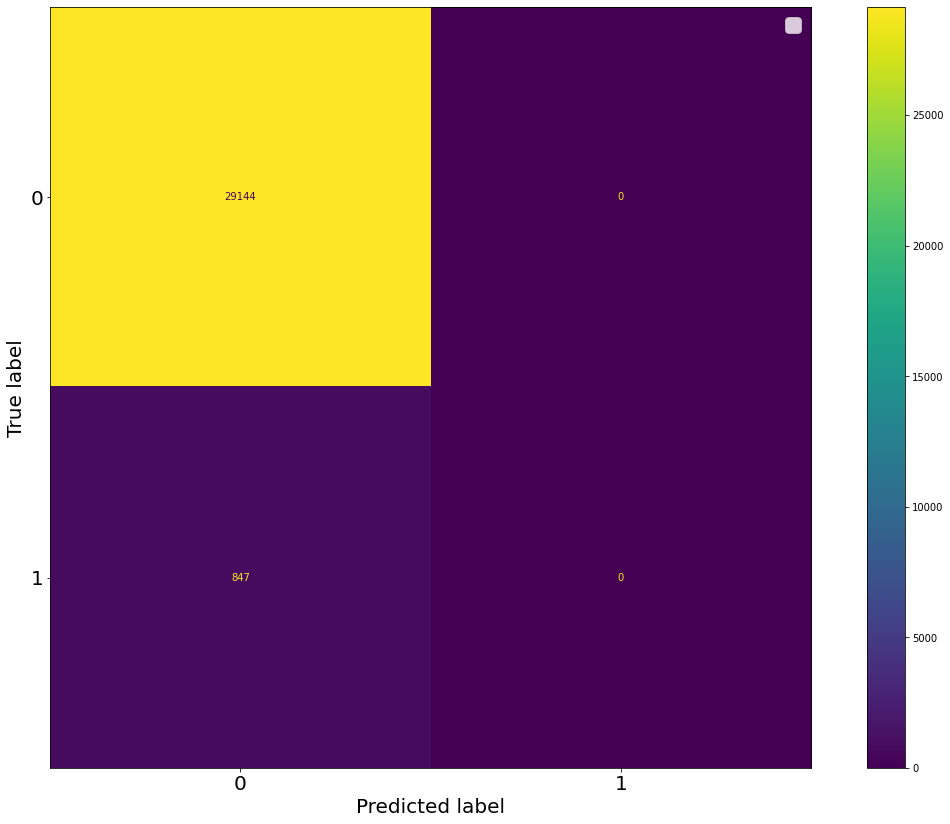

In [61]:
with open("XGBv2_best_estimator_classifier_ND.pkl", 'rb') as file:
    xgb_clf = joblib.load(file)
    
confusion_cv(train_df, X_train, y_train, classifier=xgb_clf, fontsize=20, filename="XGB_confusion_cv.png")

# Naive classifier performance

In [174]:
gkf_cv = StratifiedGroupKFold(shuffle=True, random_state=42, n_splits=3)
splitter_cv = gkf_cv.split(train_df, y_train, groups=train_df['policy_id'])

#X_train_filled = pd.DataFrame(fill_pipe.fit_transform(X_train, y_train), columns = [ele.split('__')[1] for ele in fill_pipe.named_steps["fill_na"].get_feature_names_out()])
for train, test in splitter_cv:
    
    gt = y_train.values[test]
    predicted = LR_search.predict(X_train.reset_index().loc[test, :])
    
    #print(LR_search.predict(X_train_filled.loc[test, :]))
    #print(accuracy_score(gt, predicted), accuracy_score(gt, [0] * len(gt)))
    print(f1_score(gt, predicted), f1_score(gt, [1] * len(gt)))

0.1693548387096774 0.06055555555555556
0.12871287128712872 0.04503753127606338
0.16521739130434784 0.050499445061043285


# Univariate analysis (99% conf, truncated regression, full classification)

invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, True, False, True]
[True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, True, False, True, False, True, True, True, True, True, True, True, True, True]


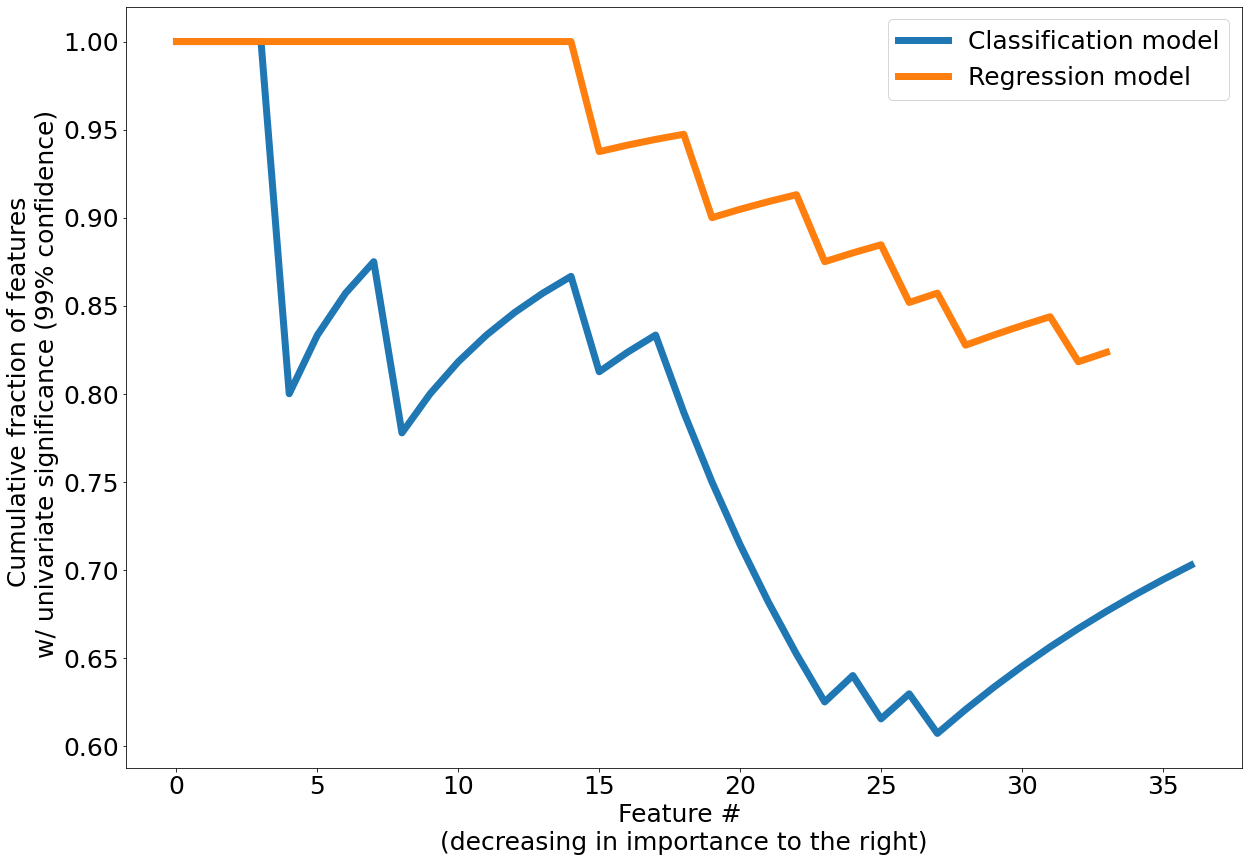

In [263]:
# analysis corresponding to features from classifier
investigate_classification = ['rate_change', 'size_of_firm_bucket', 'base_rate_factor', 'schedule_modification_factor', 'renewed_count', 'experience_modification_factor', 'defense_outside', 'max_detailed_aop_pct', 'rate_type_cd', 'high_risk_indicator', 'aop_low_risk', 'aop_independent_risk', 'increased_limits_factor', 'new_exposure', 'rule_2_total', 'factor_aop_intellectual_property_c_p_t_not_including_litigation', 'aop_above_average_risk', 'deductible_factor', 'rule_1_single_dabbler', 'edition', 'renewed_days_inforce', 'days_inforce', 'pt_att', 'rule_1_non_dabbler', 'max_detailed_aop_name', 'extended_reporting_period_type', 'extended_reporting_period_indicator', 'rule_3_multiple_dabbler', 'producer_name', 'average_step_factor', 'max_detailed_aop', 'producer_id', 'producer', 'pro_rata_factor', 'above_average_risk_indicator', 'rule_3_total', 'non_discretionary_modification_factor']
classification_significances = []

# classification significance exploration
for col in investigate_classification:
    if col in nominal_to_keep:
        
        sig = univariate_cat(preprocess_df, col, "bad_lr", 
                             filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", 
                             fontsize=20, target_binary=True, plot=False, excl_missing_sig=True, ylabel='LR class fraction')
        
    elif col in numerical_to_keep:
        sig = univariate_num(preprocess_df, col, "bad_lr", n_buckets=10, 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", 
                         fontsize=20, target_binary=True, plot=False, excl_missing_sig=True, ylabel='LR class fraction')
    else:
        print("column name shouldn't be here..")
        
    classification_significances.append(sig)

investigate_regression = ['rate_change', 'defense_outside', 'schedule_modification_factor', 'not_greater_financial_crisis', 'factor_aop_residential_real_estate_title', 'factor_aop_commercial_real_estate_title', 'factor_aop_estate_probate_trust', 'increased_limits_factor', 'non_discretionary_modification_factor', 'size_of_firm_factor', 'aop_low_risk', 'factor_aop_insurance_opinions', 'aggregate_deductible_amount', 'dominat_aop_group', 'max_detailed_aop', 'AOP_adjustment_ratio', 'renewed_exposure', 'rule_2_total', 'policy_prefix_code', 'policy_lenght_days', 'average_step_factor', 'factor_aop_family_law', 'pa_other_states', 'factor_aop_pension_employee_benefits', 'factor_aop_financial_planning', 'extended_reporting_period_indicator', 'webinar_factor', 'factor_aop_personal_injury_and_negligence_defense', 'aop_high_risk', 'extended_reporting_period_type', 'producer_external', 'limit_type', 'renewed_days_inforce', 'rate_type_cd']
regression_significances = []

# regression significance exploration
for col in investigate_regression:
    if col in nominal_to_keep:
        
        sig = univariate_cat(preprocess_df[(preprocess_df["ultimate_trended_onlevel_lr"]) <=15], col, "ultimate_trended_onlevel_lr", 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromreg_" + col + ".png", 
                         fontsize=20, target_binary=False, excl_missing_sig=False, plot=False)
        
    elif col in numerical_to_keep:
        
        sig = univariate_num(preprocess_df[(preprocess_df["ultimate_trended_onlevel_lr"]) <=15], col, "ultimate_trended_onlevel_lr", n_buckets=10, 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromreg_" + col + ".png", 
                         fontsize=20, target_binary=False, excl_missing_sig=False, plot=False)
    else:
        print("column name shouldn't be here..")
        
    regression_significances.append(sig)
    
regression_sig_cumulative = []  
for i in range(len(regression_significances)):
    regression_sig_cumulative.append(np.mean(regression_significances[0:i+1]))
    
classification_sig_cumulative = []
for i in range(len(classification_significances)):
    classification_sig_cumulative.append(np.mean(classification_significances[0:i+1]))

print(regression_significances)
print(classification_significances)

size=25
plt.plot(classification_sig_cumulative, label='Classification model', lw=7)
plt.plot(regression_sig_cumulative, label='Regression model', lw=7)

plt.xlabel("Feature # \n(decreasing in importance to the right)", fontsize=size)
plt.ylabel("Cumulative fraction of features \n w/ univariate significance (99% confidence)", fontsize=size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.legend(fontsize=fontsize)
#plt.xscale('log')
plt.savefig("cumulative_univariate_importance_99_trunc_reg_full_class_nomissingjustlog.png", dpi=300, bbox_inches="tight")

# Univariate analysis (99% conf, truncated regression, truncated classification)

invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, False, True, False, False, True, False, False, False]
[True, True, True, True, False, False, True, True, True, True, True, True, False, False, True, False, True, False, False, True, True, True, False, True, True, True, True, True, False, False, True, True, True, False, True, True, True, False, False, False, False, True, False]


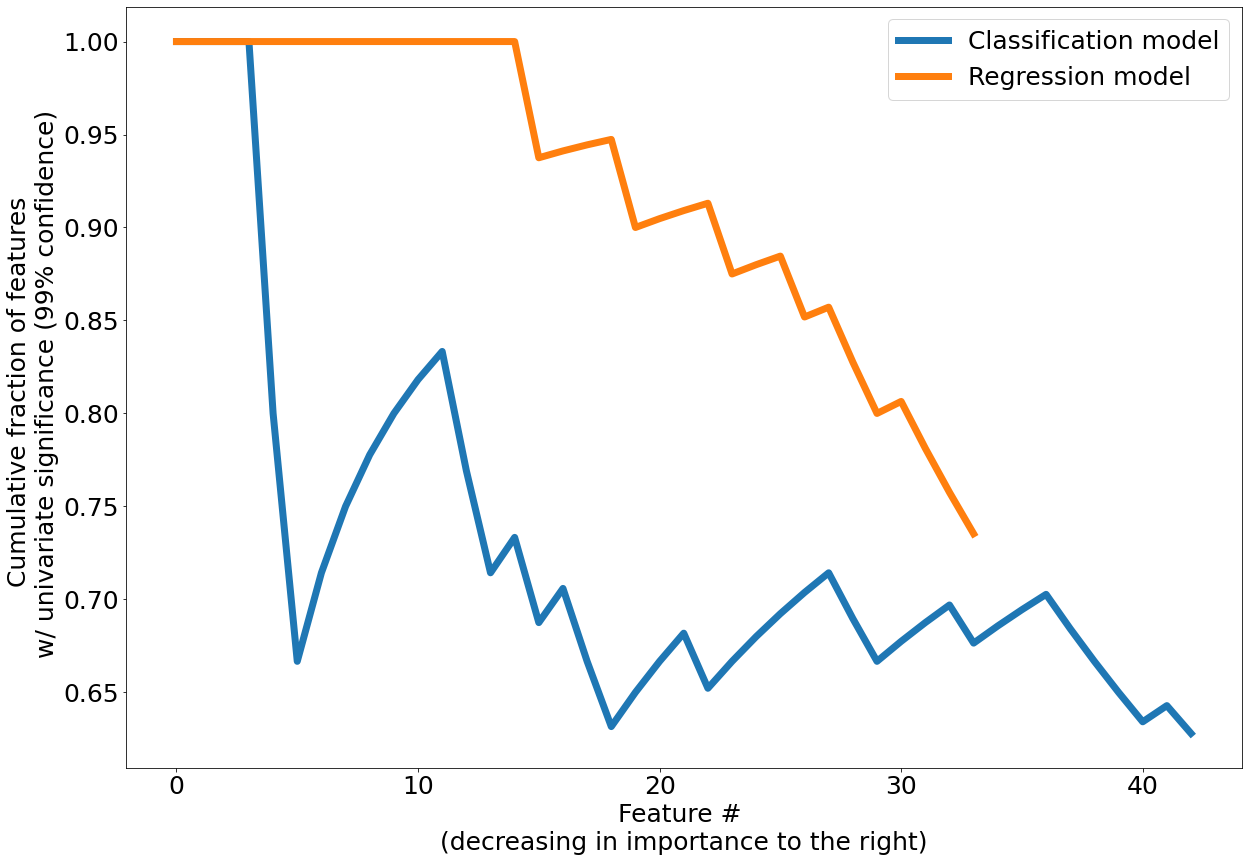

In [261]:
# analysis corresponding to features from classifier

investigate_classification = ['rate_change', 'size_of_firm_bucket', 'base_rate_factor', 'defense_outside', 'pt_att', 'rate_type_cd', 'schedule_modification_factor', 'increased_limits_factor', 'experience_modification_factor', 'size_of_firm_factor', 'exposure_renewed_retention', 'new_exposure', 'rule_1_non_dabbler', 'aop_independent_risk', 'aop_above_average_risk', 'factor_aop_intellectual_property_c_p_t_not_including_litigation', 'max_detailed_aop_pct', 'higher_rate_factor', 'extended_reporting_period_type', 'extended_reporting_period_indicator', 'deductible_type', 'high_risk_indicator', 'renewed_days_inforce', 'product_modified', 'product', 'legal_entity', 'admitted_vs_notadmitted', 'max_detailed_aop_name', 'AOP_adjustment_ratio', 'surcharge', 'producer', 'producer_external', 'producer_id', 'edition', 'policy_prefix_code', 'factor_aop_estate_probate_trust', 'producer_name', 'limit_type', 'status_production_na_as_new', 'status_production_na_as_renewed', 'insurance_company_id', 'above_average_risk_indicator', 'policy_lenght_days']
classification_significances = []

# classification significance exploration
for col in investigate_classification:
    if col in nominal_to_keep:
        
        sig = univariate_cat(preprocess_df[(preprocess_df["ultimate_trended_onlevel_lr"]) <=15], col, "bad_lr", 
                             filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", 
                             fontsize=20, target_binary=True, plot=False, excl_missing_sig=True, ylabel='LR class fraction')
        
    elif col in numerical_to_keep:
        sig = univariate_num(preprocess_df[(preprocess_df["ultimate_trended_onlevel_lr"]) <=15], col, "bad_lr", n_buckets=10, 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", 
                         fontsize=20, target_binary=True, plot=False, excl_missing_sig=True, ylabel='LR class fraction')
    else:
        print("column name shouldn't be here..")
        
    classification_significances.append(sig)

investigate_regression = ['rate_change', 'defense_outside', 'schedule_modification_factor', 'not_greater_financial_crisis', 'factor_aop_residential_real_estate_title', 'factor_aop_commercial_real_estate_title', 'factor_aop_estate_probate_trust', 'increased_limits_factor', 'non_discretionary_modification_factor', 'size_of_firm_factor', 'aop_low_risk', 'factor_aop_insurance_opinions', 'aggregate_deductible_amount', 'dominat_aop_group', 'max_detailed_aop', 'AOP_adjustment_ratio', 'renewed_exposure', 'rule_2_total', 'policy_prefix_code', 'policy_lenght_days', 'average_step_factor', 'factor_aop_family_law', 'pa_other_states', 'factor_aop_pension_employee_benefits', 'factor_aop_financial_planning', 'extended_reporting_period_indicator', 'webinar_factor', 'factor_aop_personal_injury_and_negligence_defense', 'aop_high_risk', 'extended_reporting_period_type', 'producer_external', 'limit_type', 'renewed_days_inforce', 'rate_type_cd']
regression_significances = []

# regression significance exploration
for col in investigate_regression:
    if col in nominal_to_keep:
        
        sig = univariate_cat(preprocess_df[(preprocess_df["ultimate_trended_onlevel_lr"]) <=15], col, "ultimate_trended_onlevel_lr", 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromreg_" + col + ".png", 
                         fontsize=20, target_binary=False, excl_missing_sig=False, plot=False)
        
    elif col in numerical_to_keep:
        
        sig = univariate_num(preprocess_df[(preprocess_df["ultimate_trended_onlevel_lr"]) <=15], col, "ultimate_trended_onlevel_lr", n_buckets=10, 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromreg_" + col + ".png", 
                         fontsize=20, target_binary=False, excl_missing_sig=False, plot=False)
    else:
        print("column name shouldn't be here..")
        
    regression_significances.append(sig)
    
regression_sig_cumulative = []  
for i in range(len(regression_significances)):
    regression_sig_cumulative.append(np.mean(regression_significances[0:i+1]))
    
classification_sig_cumulative = []
for i in range(len(classification_significances)):
    classification_sig_cumulative.append(np.mean(classification_significances[0:i+1]))

print(regression_significances)
print(classification_significances)

size=25
plt.plot(classification_sig_cumulative, label='Classification model', lw=7)
plt.plot(regression_sig_cumulative, label='Regression model', lw=7)

plt.xlabel("Feature # \n(decreasing in importance to the right)", fontsize=size)
plt.ylabel("Cumulative fraction of features \n w/ univariate significance (99% confidence)", fontsize=size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.legend(fontsize=fontsize)
#plt.xscale('log')
plt.savefig("cumulative_univariate_importance_99_trunc_reg_trunc_class_nomissingjustlog.png", dpi=300, bbox_inches="tight")

# Univariate analysis (99% conf, capped regression, full classification)

invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply


[True, False, True, False, False, True, False, True, True, True, False, False, False, False, False, False, False, True, False, True, False, True, True, False, True, True, False, True, False, False, False, False, True, False, True, False, True, False, False, True, False, False, True, False, False, True]
[True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, True, False, True, False, True, True, True, True, True, True, True, True, True]


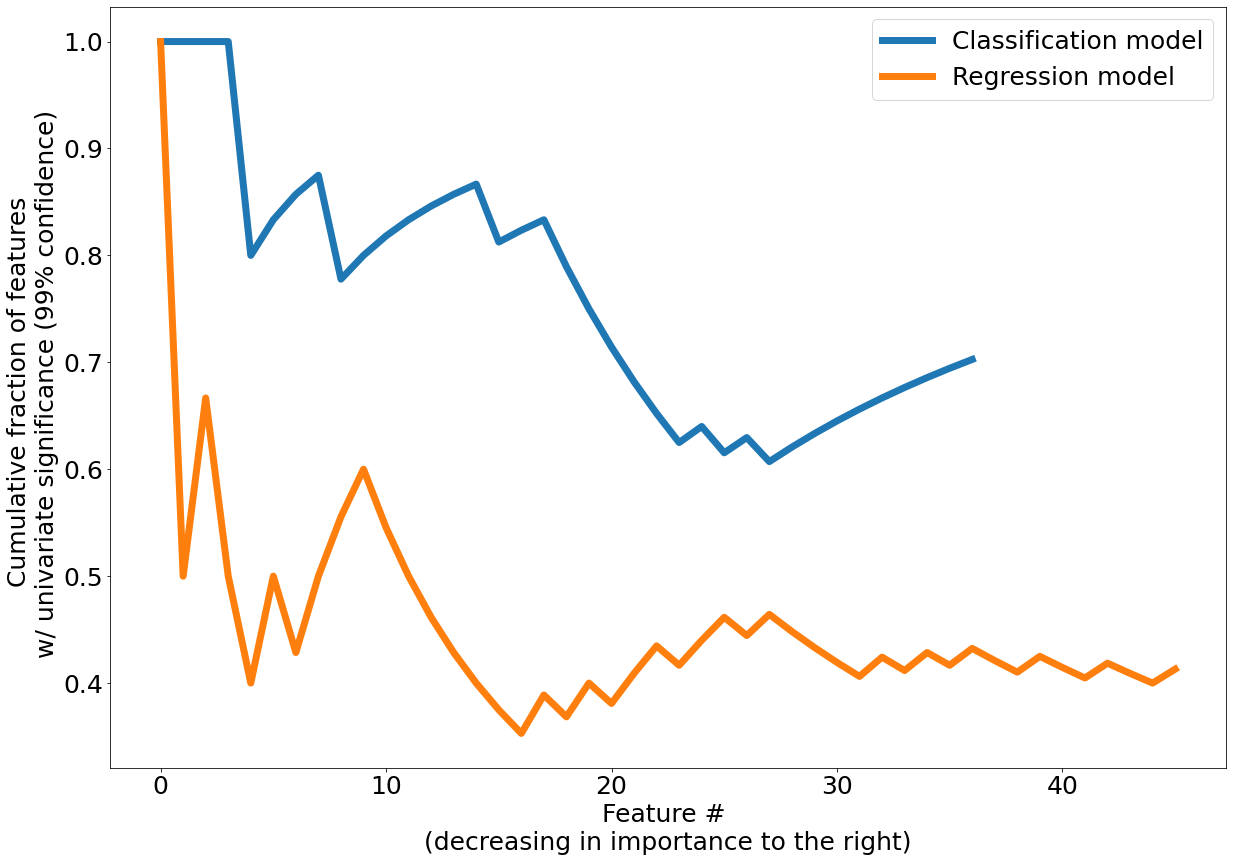

In [262]:
# analysis corresponding to features from classifier

investigate_classification = ['rate_change', 'size_of_firm_bucket', 'base_rate_factor', 'schedule_modification_factor', 'renewed_count', 'experience_modification_factor', 'defense_outside', 'max_detailed_aop_pct', 'rate_type_cd', 'high_risk_indicator', 'aop_low_risk', 'aop_independent_risk', 'increased_limits_factor', 'new_exposure', 'rule_2_total', 'factor_aop_intellectual_property_c_p_t_not_including_litigation', 'aop_above_average_risk', 'deductible_factor', 'rule_1_single_dabbler', 'edition', 'renewed_days_inforce', 'days_inforce', 'pt_att', 'rule_1_non_dabbler', 'max_detailed_aop_name', 'extended_reporting_period_type', 'extended_reporting_period_indicator', 'rule_3_multiple_dabbler', 'producer_name', 'average_step_factor', 'max_detailed_aop', 'producer_id', 'producer', 'pro_rata_factor', 'above_average_risk_indicator', 'rule_3_total', 'non_discretionary_modification_factor']
classification_significances = []

# classification significance exploration
for col in investigate_classification:
    if col in nominal_to_keep:
        
        sig = univariate_cat(preprocess_df, col, "bad_lr", 
                             filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", 
                             fontsize=20, target_binary=True, plot=False, excl_missing_sig=True, ylabel='LR class fraction')
        
    elif col in numerical_to_keep:
        sig = univariate_num(preprocess_df, col, "bad_lr", n_buckets=10, 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", 
                         fontsize=20, target_binary=True, plot=False, excl_missing_sig=True, ylabel='LR class fraction')
    else:
        print("column name shouldn't be here..")
        
    classification_significances.append(sig)

investigate_regression = ['rate_change', 'defense_outside', 'factor_aop_insurance_opinions', 'schedule_modification_factor', 'max_detailed_aop_pct', 'aop_low_risk', 'base_rate_factor', 'exposure_renewed_retention', 'deductible_factor', 'increased_limits_factor', 'aop_average_risk', 'average_step_factor', 'webinar_factor', 'days_inforce', 'factor_aop_financial_planning', 'factor_aop_intellectual_property_c_p_t_not_including_litigation', 'not_greater_financial_crisis', 'risk_category', 'above_average_risk_indicator', 'factor_aop_estate_probate_trust', 'edition', 'area_of_practice_factor', 'max_detailed_aop_name', 'non_discretionary_modification_factor', 'producer_id', 'producer_name', 'experience_modification_factor', 'AOP_adjustment_ratio', 'rule_3_total', 'factor_aop_commercial_real_estate_title', 'occurrence_limit', 'aop_high_risk', 'aggregate_deductible_amount', 'size_of_firm_factor', 'factor_aop_residential_real_estate_title', 'extended_reporting_period_indicator', 'dominat_aop_group', 'new_exposure', 'quater', 'deductible_type', 'factor_aop_collection_bankruptcy', 'aop_above_average_risk', 'program_code', 'factor_aop_pension_employee_benefits', 'aop_below_average_risk', 'factor_aop_family_law']
regression_significances = []

# regression significance exploration
for col in investigate_regression:
    if col in nominal_to_keep:
        
        sig = univariate_cat(preprocess_df, col, "ultimate_trended_onlevel_lr", 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromreg_" + col + ".png", 
                         fontsize=20, target_binary=False, excl_missing_sig=True, plot=False)
        
    elif col in numerical_to_keep:
        
        sig = univariate_num(preprocess_df, col, "ultimate_trended_onlevel_lr", n_buckets=10, 
                         filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromreg_" + col + ".png", 
                         fontsize=20, target_binary=False, excl_missing_sig=True, plot=False)
    else:
        print("column name shouldn't be here..")
        
    regression_significances.append(sig)
    
regression_sig_cumulative = []  
for i in range(len(regression_significances)):
    regression_sig_cumulative.append(np.mean(regression_significances[0:i+1]))
    
classification_sig_cumulative = []
for i in range(len(classification_significances)):
    classification_sig_cumulative.append(np.mean(classification_significances[0:i+1]))

print(regression_significances)
print(classification_significances)

size=25
plt.plot(classification_sig_cumulative, label='Classification model', lw=7)
plt.plot(regression_sig_cumulative, label='Regression model', lw=7)

plt.xlabel("Feature # \n(decreasing in importance to the right)", fontsize=size)
plt.ylabel("Cumulative fraction of features \n w/ univariate significance (99% confidence)", fontsize=size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.legend(fontsize=fontsize)
#plt.xscale('log')
plt.savefig("cumulative_univariate_importance_99_capped_reg_full_class_nomissing.png", dpi=300, bbox_inches="tight")

## Nominal marginal plots

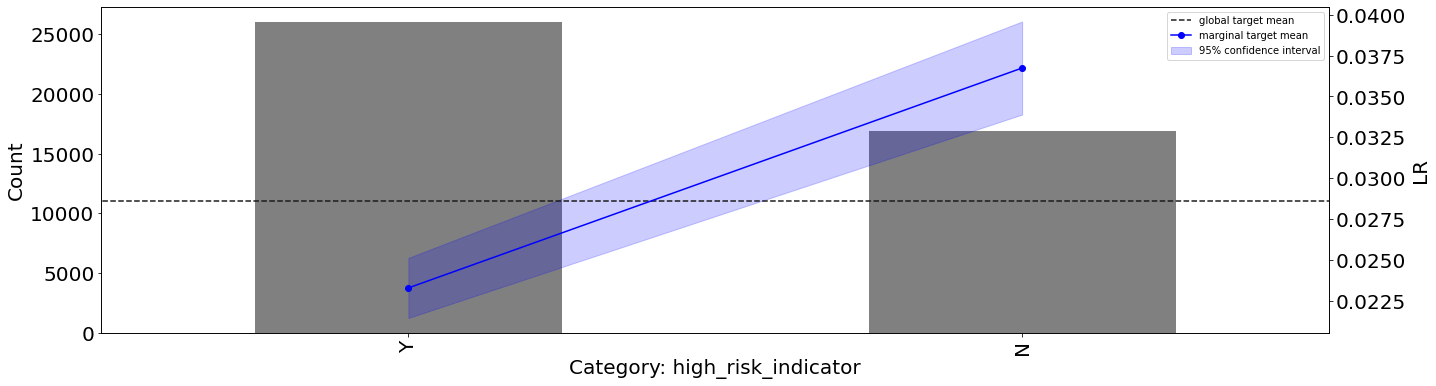

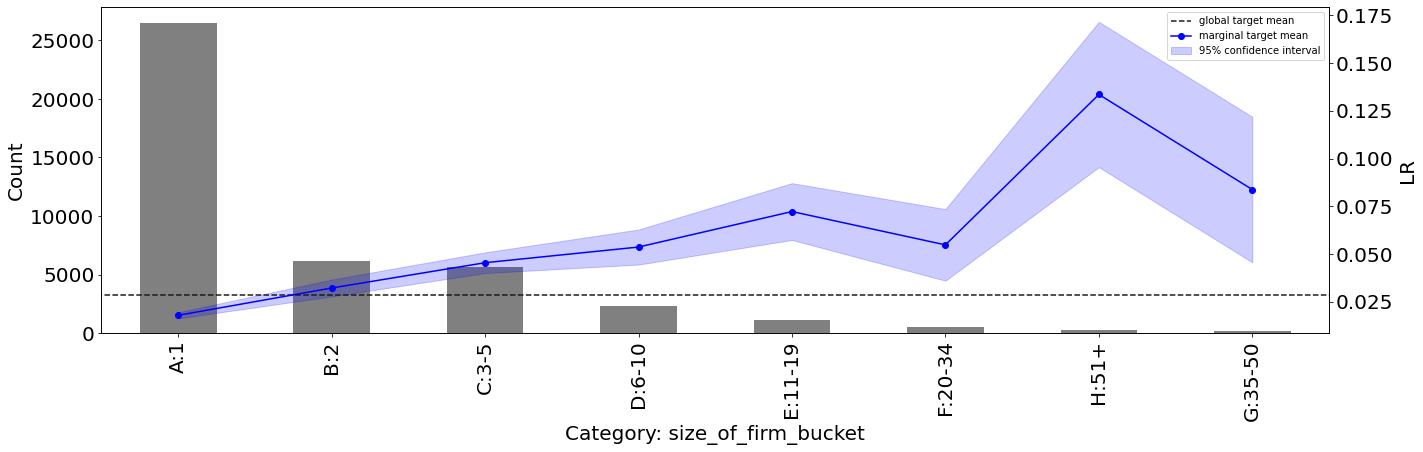

[True, True]


In [189]:
classification_significances = []
for col in nominal_to_investigate:
    sig = univariate_cat(preprocess_df, col, "bad_lr", filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_" + col + ".png", fontsize=20)
    significances.append(sig)
    
print(significances)
#     univariate_cat(preprocess_df, col, "ultimate_trended_onlevel_lr", filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_" + col + ".png", fontsize=20)
#     univariate_cat(preprocess_df, col, "bad_lr", filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_" + col + ".png", fontsize=20)
    #univariate_cat(preprocess_df, col, "bad_lr", fontsize=25)

# Numerical univariate plots

                    mean  count  sum  \
quantile_cat                           
(-0.001, 0.05]  0.027920  23245  649   
(0.05, 0.1]     0.035267   3516  124   
(0.1, 0.2]      0.041531   3997  166   
(0.2, 0.375]    0.033778   3523  119   
(0.375, 0.75]   0.025802   4302  111   
(0.75, 1.0]     0.013142   4261   56   

                                                             list  \
quantile_cat                                                        
(-0.001, 0.05]  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...   
(0.05, 0.1]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...   
(0.1, 0.2]      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   
(0.2, 0.375]    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...   
(0.375, 0.75]   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(0.75, 1.0]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                global_mean  lower_95_bound  upper_95_bound  
quantile_cat                                                 
(-

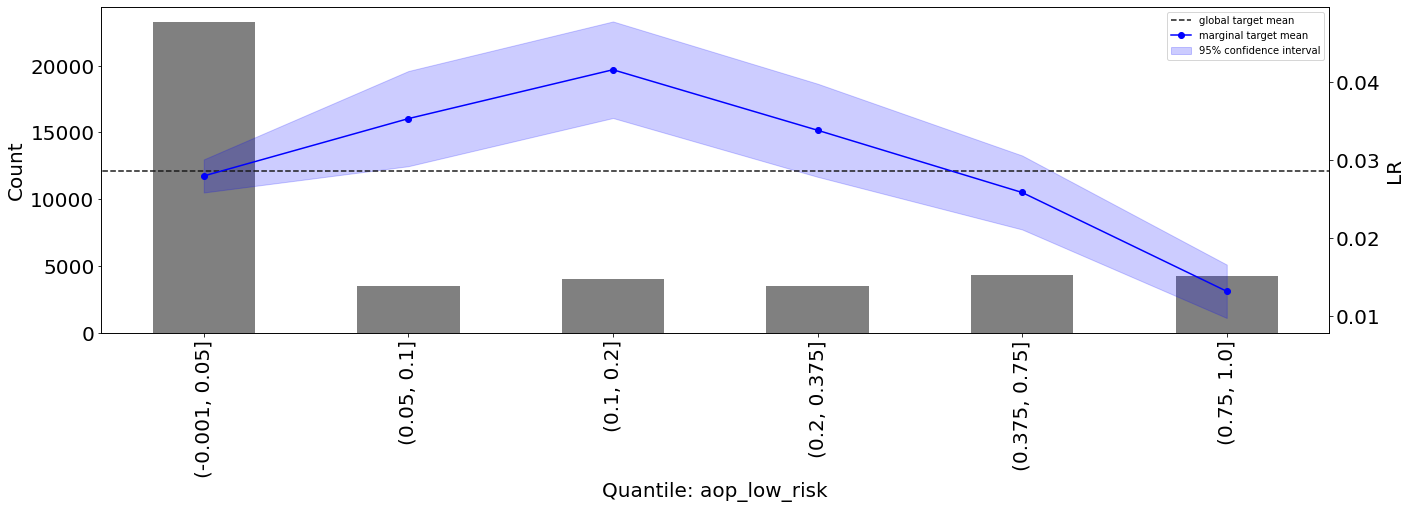

                    mean  count  sum  \
quantile_cat                           
(-0.001, 1.22]  0.017256   4578   79   
(1.22, 1.65]    0.017411   5686   99   
(1.65, 1.75]    0.026562   3426   91   
(1.75, 1.93]    0.018995   3422   65   
(1.93, 2.0]     0.025582   6528  167   
(2.0, 2.1]      0.020784   2550   53   
(2.1, 2.2]      0.037137   4793  178   
(2.2, 2.53]     0.031910   4074  130   
(2.53, 2.94]    0.039125   3476  136   
(2.94, 5.04]    0.053453   4228  226   
missing         0.012048     83    1   

                                                             list  \
quantile_cat                                                        
(-0.001, 1.22]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...   
(1.22, 1.65]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   
(1.65, 1.75]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(1.75, 1.93]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
(1.93, 2.0]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

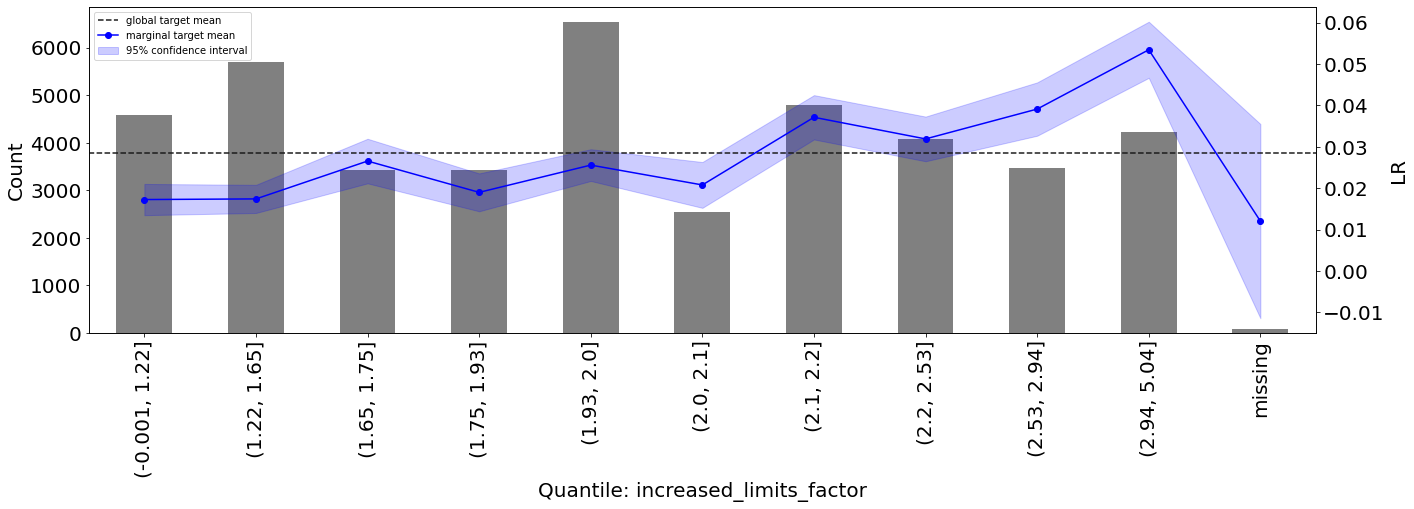

                   mean  count   sum  \
quantile_cat                           
(-0.001, 1.0]  0.026787  38489  1031   
(1.0, 2.0]     0.043275   3628   157   
(2.0, 3.0]     0.050894    727    37   

                                                            list  global_mean  \
quantile_cat                                                                    
(-0.001, 1.0]  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...     0.028592   
(1.0, 2.0]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...     0.028592   
(2.0, 3.0]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   

               lower_95_bound  upper_95_bound  
quantile_cat                                   
(-0.001, 1.0]        0.025174        0.028400  
(1.0, 2.0]           0.036654        0.049896  
(2.0, 3.0]           0.034918        0.066870  
True


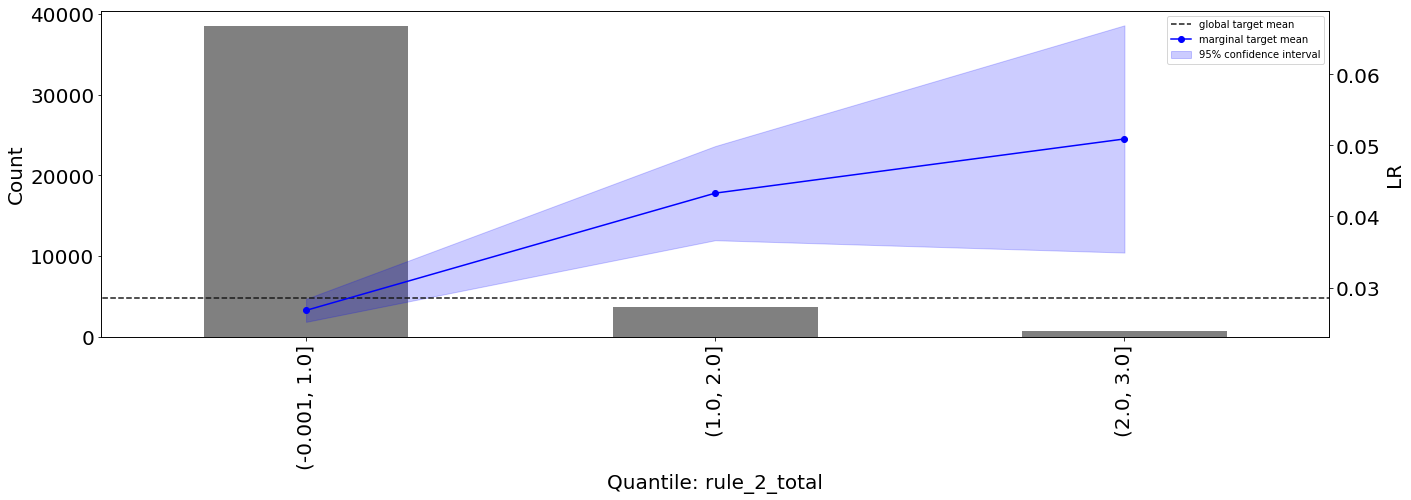

invalid value encountered in multiply
invalid value encountered in multiply


                  mean  count  sum  \
quantile_cat                         
(0.649, 0.9]  0.029505  14133  417   
(0.9, 0.95]   0.033321   5462  182   
(0.95, 0.98]  0.028231   3613  102   
(0.98, 1.0]   0.019571  16146  316   
(1.0, 1.833]  0.059701   3484  208   
missing       0.000000      6    0   

                                                           list  global_mean  \
quantile_cat                                                                   
(0.649, 0.9]  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(0.9, 0.95]   [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...     0.028592   
(0.95, 0.98]  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(0.98, 1.0]   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(1.0, 1.833]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
missing                                      [0, 0, 0, 0, 0, 0]     0.028592   

              lower_95_bound  upper_95_bound  
quantil

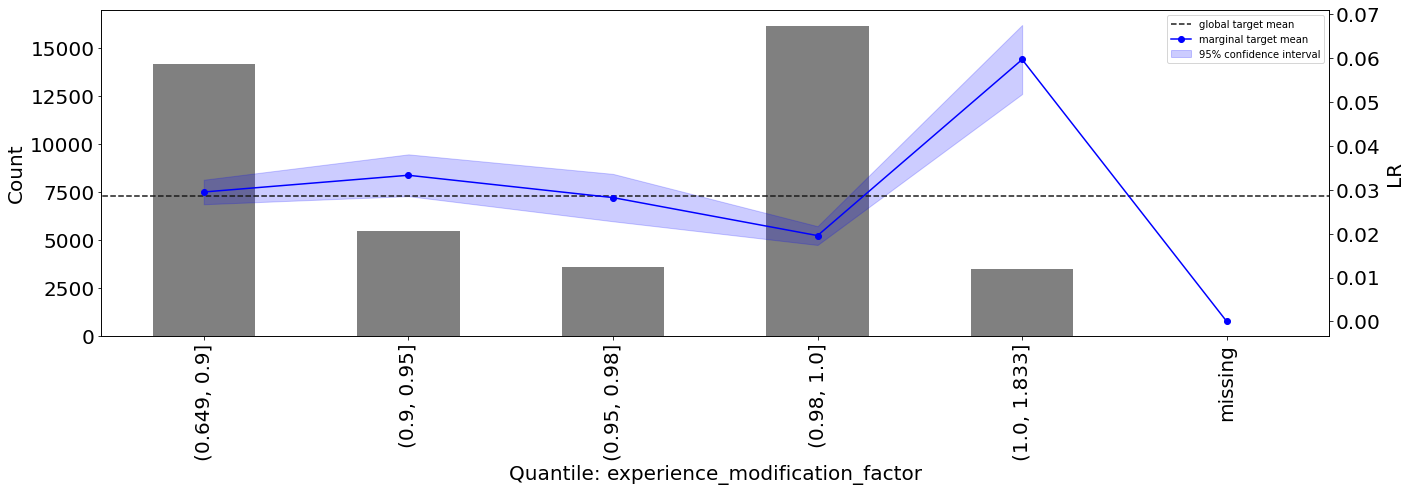

                      mean  count  sum  \
quantile_cat                             
(1171.0, 1439.0]  0.030478   4331  132   
(1439.0, 5918.0]  0.037065   3939  146   
(488.0, 536.0]    0.033187   3646  121   
(536.0, 587.0]    0.025551   5401  138   
(587.0, 610.0]    0.027275   4913  134   
(610.0, 650.0]    0.030537   2587   79   
(650.0, 778.0]    0.028756   4173  120   
(778.0, 989.0]    0.025138   4336  109   
(97.999, 488.0]   0.018208   4943   90   
(989.0, 1171.0]   0.034506   4492  155   
missing           0.012048     83    1   

                                                               list  \
quantile_cat                                                          
(1171.0, 1439.0]  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(1439.0, 5918.0]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...   
(488.0, 536.0]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(536.0, 587.0]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(587.0, 610.0]    [0, 0, 0,

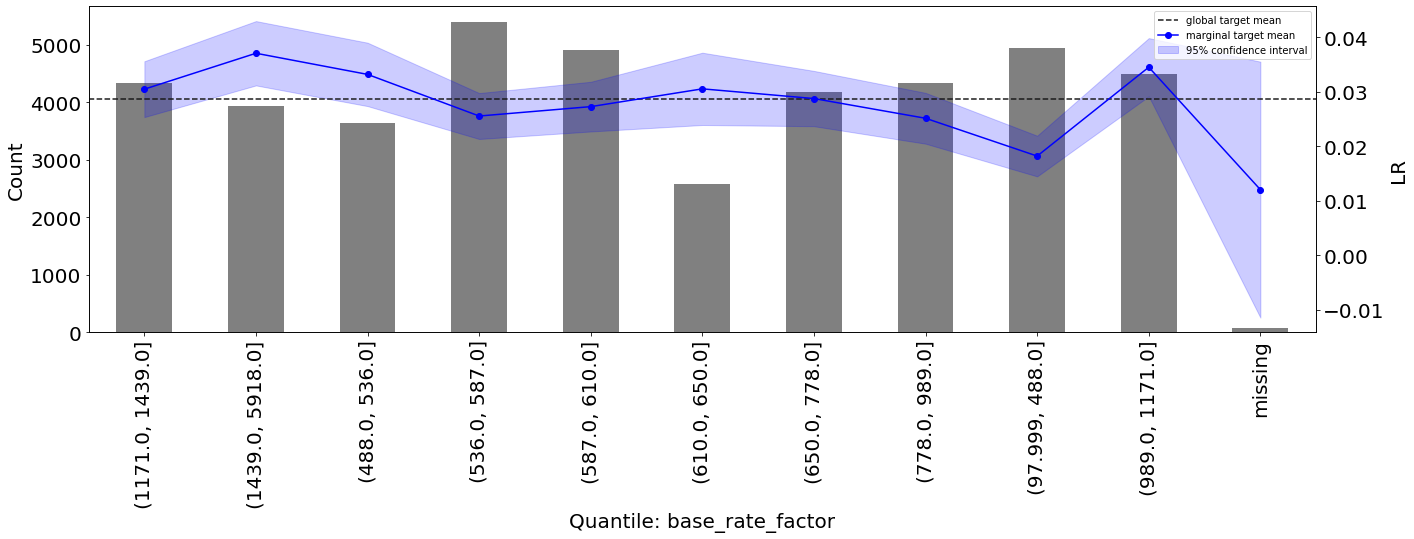

invalid value encountered in multiply
invalid value encountered in multiply


                          mean  count  sum  \
quantile_cat                                 
(118.999, 929.0]      0.005659   4241   24   
(1737.0, 2375.0]      0.013676   4241   58   
(18777.6, 839421.0]   0.072170   4240  306   
(2375.0, 2975.0]      0.022422   4237   95   
(2975.0, 3688.665]    0.024534   4239  104   
(3688.665, 4730.768]  0.027594   4240  117   
(4730.768, 6454.9]    0.031375   4239  133   
(6454.9, 9772.0]      0.034426   4241  146   
(929.0, 1737.0]       0.010375   4241   44   
(9772.0, 18777.6]     0.046709   4239  198   
missing               0.000000    446    0   

                                                                   list  \
quantile_cat                                                              
(118.999, 929.0]      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(1737.0, 2375.0]      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(18777.6, 839421.0]   [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...   
(2375.0, 2975.0]      [0, 

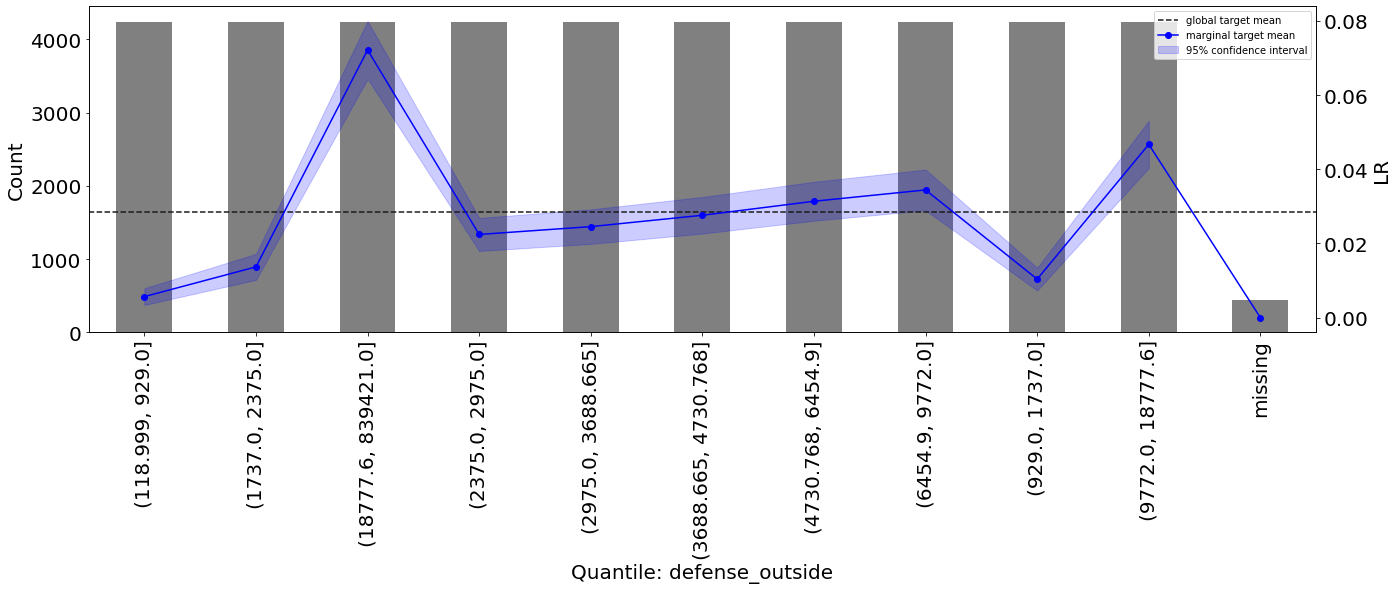

                   mean  count   sum  \
quantile_cat                           
(-0.001, 0.1]  0.027738  38755  1075   
(0.1, 1.0]     0.036684   4089   150   

                                                            list  global_mean  \
quantile_cat                                                                    
(-0.001, 0.1]  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...     0.028592   
(0.1, 1.0]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...     0.028592   

               lower_95_bound  upper_95_bound  
quantile_cat                                   
(-0.001, 0.1]        0.026103        0.029373  
(0.1, 1.0]           0.030922        0.042446  
True


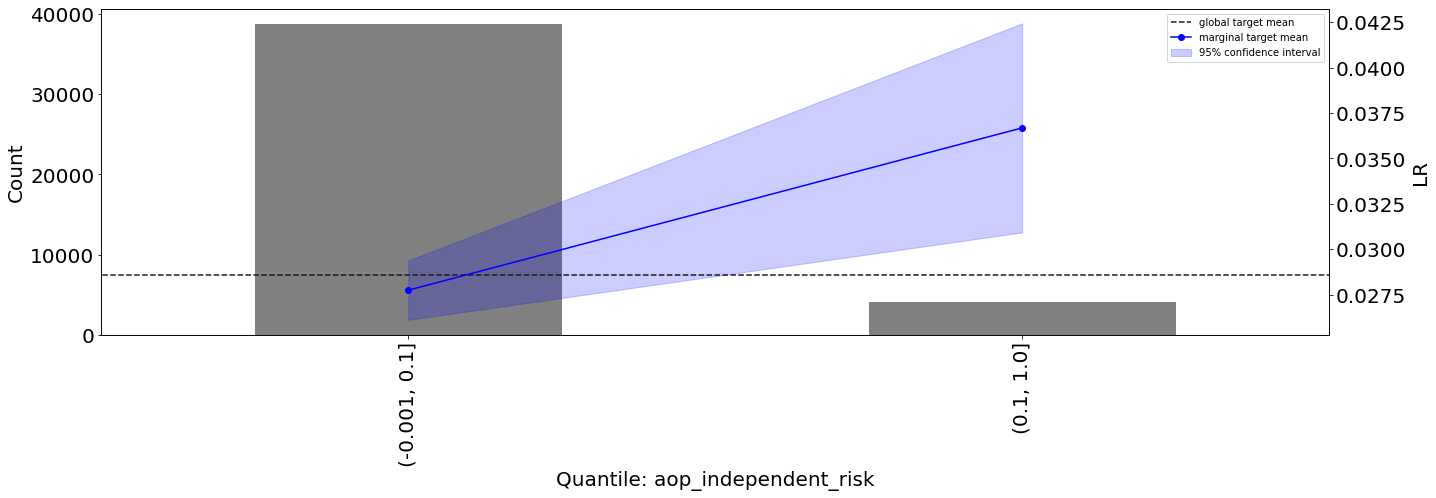

                  mean  count   sum  \
quantile_cat                          
(0.999, 9.0]  0.027593  41786  1153   
missing       0.068053   1058    72   

                                                           list  global_mean  \
quantile_cat                                                                   
(0.999, 9.0]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
missing       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...     0.028592   

              lower_95_bound  upper_95_bound  
quantile_cat                                  
(0.999, 9.0]        0.026022        0.029164  
missing             0.052878        0.083228  
True


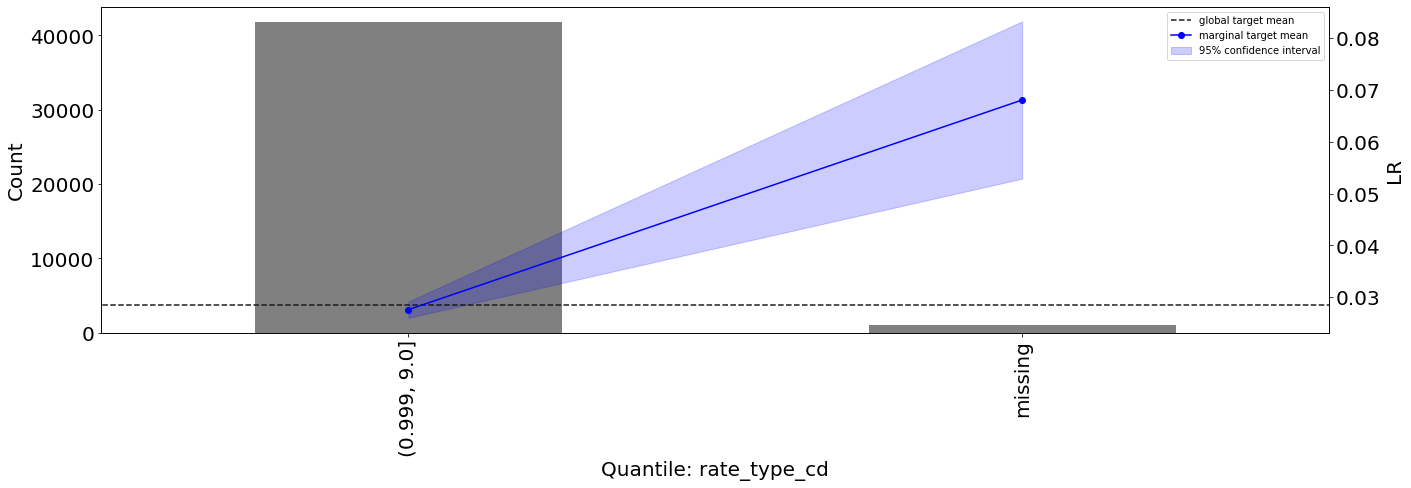

                   mean  count   sum  \
quantile_cat                           
(-0.001, 1.0]  0.027836  40415  1125   
(1.0, 191.0]   0.041169   2429   100   

                                                            list  global_mean  \
quantile_cat                                                                    
(-0.001, 1.0]  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...     0.028592   
(1.0, 191.0]   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   

               lower_95_bound  upper_95_bound  
quantile_cat                                   
(-0.001, 1.0]        0.026232         0.02944  
(1.0, 191.0]         0.033268         0.04907  
True


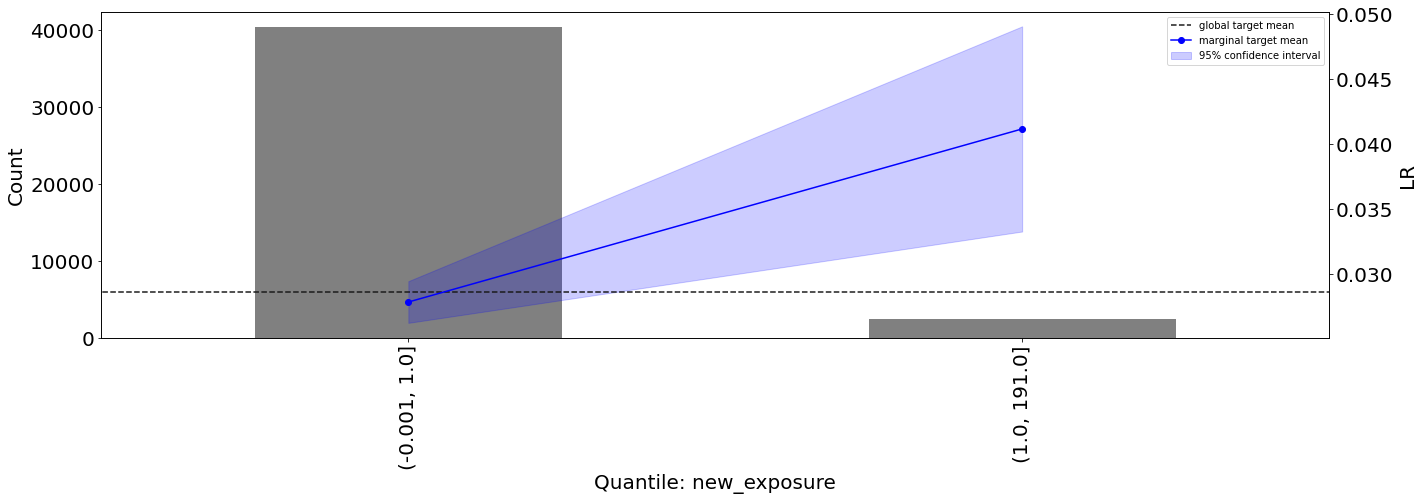

                   mean  count  sum  \
quantile_cat                          
(30.0, 40.0]   0.033444   5113  171   
(40.0, 48.0]   0.035942   2198   79   
(48.0, 50.0]   0.026946   4342  117   
(50.0, 65.0]   0.030415   4866  148   
(65.0, 75.0]   0.021513   4137   89   
(75.0, 86.0]   0.024584   3783   93   
(86.0, 95.0]   0.024539   4768  117   
(9.999, 30.0]  0.044042   5631  248   
(95.0, 100.0]  0.020360   8006  163   

                                                            list  global_mean  \
quantile_cat                                                                    
(30.0, 40.0]   [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...     0.028592   
(40.0, 48.0]   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(48.0, 50.0]   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(50.0, 65.0]   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(65.0, 75.0]   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0.028592   
(75

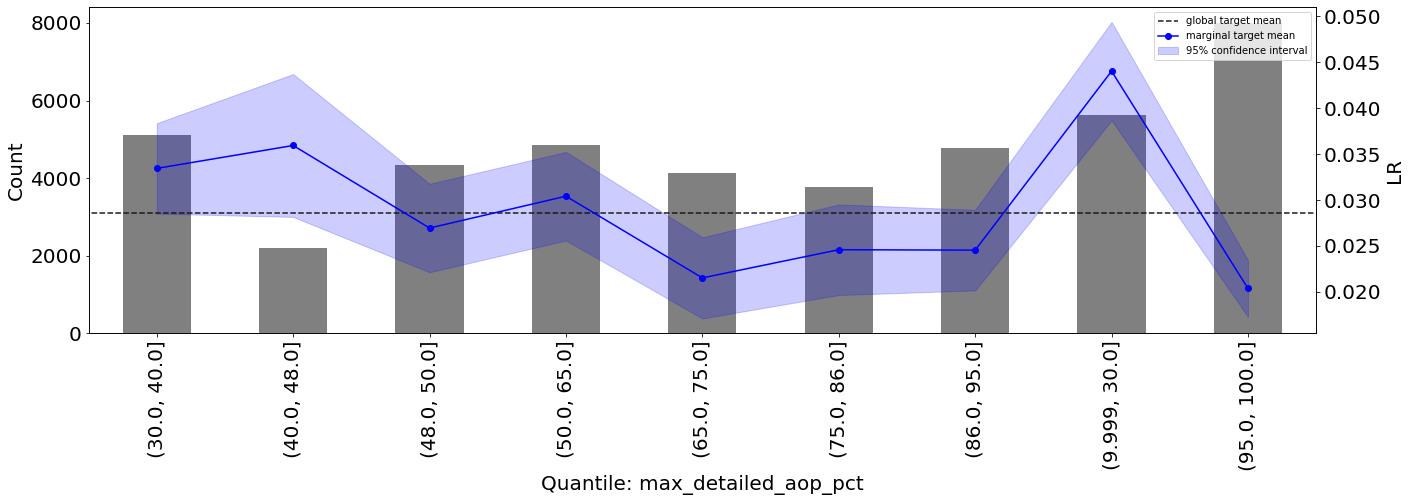

                     mean  count  sum  \
quantile_cat                            
(-1.115, 0.922]  0.017699   3390   60   
(0.922, 0.978]   0.014159   3390   48   
(0.978, 1.0]     0.011744  14986  176   
(1.0, 1.019]     0.029532   1964   58   
(1.019, 1.04]    0.020649   3390   70   
(1.04, 1.069]    0.032153   3390  109   
(1.069, 5.899]   0.123304   3390  418   
missing          0.031977   8944  286   

                                                              list  \
quantile_cat                                                         
(-1.115, 0.922]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   
(0.922, 0.978]   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(0.978, 1.0]     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   
(1.0, 1.019]     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(1.019, 1.04]    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
(1.04, 1.069]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(1.069, 5.899]   [1, 1, 0, 0,

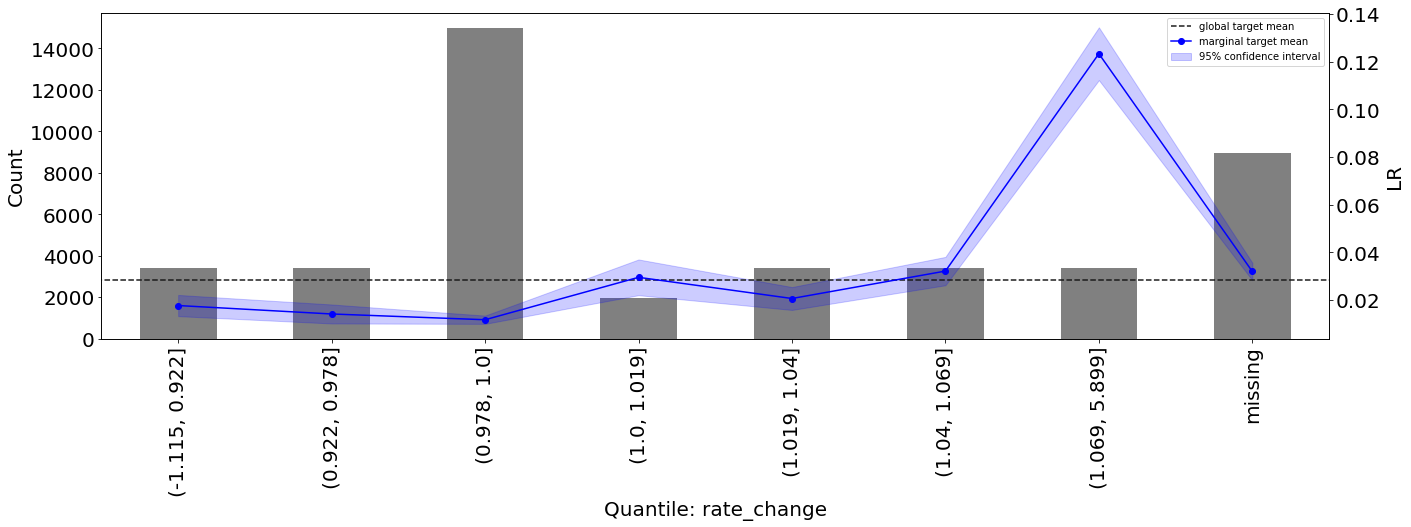

                    mean  count  sum  \
quantile_cat                           
(0.599, 0.875]  0.033000   4303  142   
(0.875, 0.95]   0.033549   5097  171   
(0.95, 0.96]    0.022257   3819   85   
(0.96, 1.0]     0.018432   9820  181   
(1.0, 1.02]     0.026937   2710   73   
(1.02, 1.06]    0.028585   4303  123   
(1.06, 1.12]    0.030857   4375  135   
(1.12, 1.2]     0.034585   4395  152   
(1.2, 1.75]     0.041127   3939  162   
missing         0.012048     83    1   

                                                             list  \
quantile_cat                                                        
(0.599, 0.875]  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(0.875, 0.95]   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
(0.95, 0.96]    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(0.96, 1.0]     [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
(1.0, 1.02]     [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
(1.02, 1.06]    [0, 0, 0, 0, 0, 0, 1

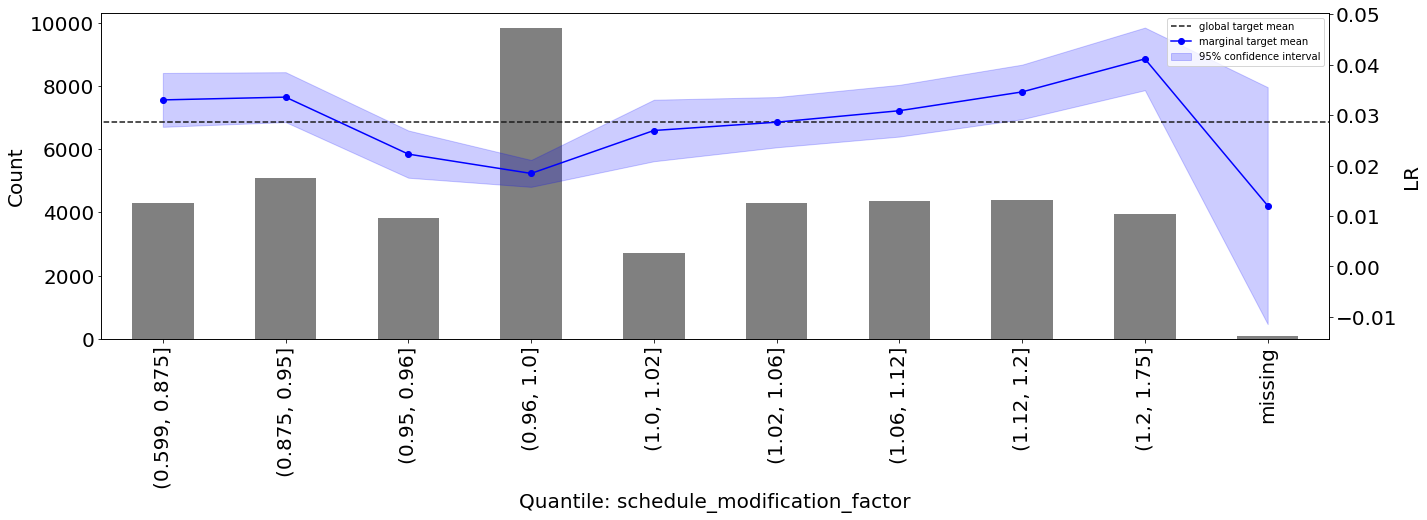

                   mean  count   sum  \
quantile_cat                           
(-0.001, 1.0]  0.028592  42844  1225   

                                                            list  global_mean  \
quantile_cat                                                                    
(-0.001, 1.0]  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...     0.028592   

               lower_95_bound  upper_95_bound  
quantile_cat                                   
(-0.001, 1.0]        0.027014         0.03017  
False


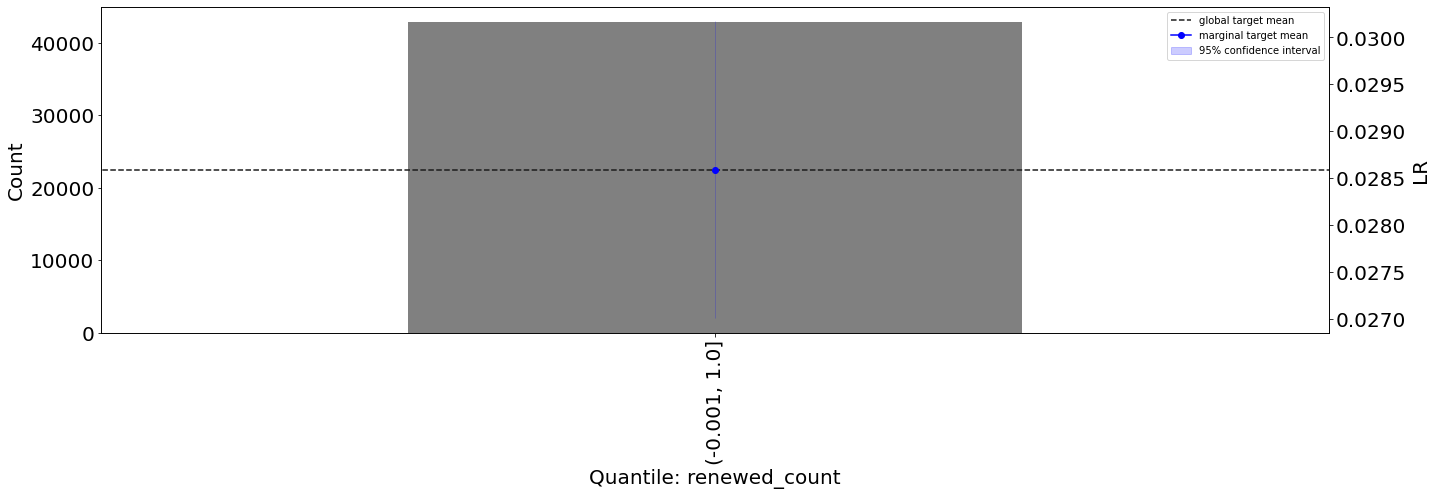

In [192]:
for col in numerical_to_investigate:
    univariate_num(preprocess_df, col, "bad_lr", n_buckets=10, filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_fromclass_" + col + ".png", fontsize=20, target_binary=False)
    #univariate_num(preprocess_df, col, "bad_lr", n_buckets=10, filename= os.getcwd() + os.sep + "Figures" + os.sep + "feature_" + col + ".png", fontsize=20, target_binary=False)
    #univariate_cat(preprocess_df, col, "bad_lr", fontsize=25)

In [141]:
preprocess_df["renewal_count"].value_counts()

1    36478
0     6366
Name: renewal_count, dtype: int64

In [277]:
preprocess_df[nominal_to_keep[0]].value_counts()

None    13880
PRSG     1201
Name: program, dtype: int64

# comparison of capped regression and truncated regression

In [266]:
with open("XGBv1_best_estimator_newpreprocessing.pkl", 'rb') as file:
      
    # Call load method to deserialze
    trunc_reg_model = joblib.load(file)

In [268]:
with open("XGBv1_best_estimator_newpreprocessing_capped.pkl", 'rb') as file:
      
    # Call load method to deserialze
    capped_reg_model = joblib.load(file)

In [276]:
mean_squared_error(test_df["ultimate_trended_onlevel_lr"], capped_reg_model.predict(X_test))

249.61276853283672

In [277]:
mean_squared_error(test_df["ultimate_trended_onlevel_lr"], trunc_reg_model.predict(X_test))

250.22298087312848